# Salary Prediction Using Ordinal Logistic Regression

## Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LassoCV
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import mean_squared_error
import mord
from sklearn.model_selection import learning_curve
import warnings
from sklearn.model_selection import GridSearchCV
import pickle
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier

warnings.filterwarnings("ignore")

## Importing Data

The dataset contains the survey results provided by https://www.kaggle.com/c/kaggle-survey-2021.

In [3]:
df= pd.read_csv('clean_kaggle_data_2021.csv')
df=df.drop(index=0)
df

,Time from Start to Finish (seconds),Q1,Q2,Q3,Q4,Q5,Q6,Q7_Part_1,Q7_Part_2,Q7_Part_3,...,Q38_B_Part_5,Q38_B_Part_6,Q38_B_Part_7,Q38_B_Part_8,Q38_B_Part_9,Q38_B_Part_10,Q38_B_Part_11,Q38_B_OTHER,Q25_Encoded,Q25_buckets
1,910,50-54,Man,India,Bachelor’s degree,Other,5-10 years,Python,R,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,"20,000-29,999"
2,784,50-54,Man,Indonesia,Master’s degree,Program/Project Manager,20+ years,NaN,NaN,SQL,...,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,6.0,"60,000-69,999"
3,924,22-24,Man,Pakistan,Master’s degree,Software Engineer,1-3 years,Python,NaN,NaN,...,TensorBoard,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,"0-9,999"
4,575,45-49,Man,Mexico,Doctoral degree,Research Scientist,20+ years,Python,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,3.0,"30,000-39,999"
5,781,45-49,Man,India,Doctoral degree,Other,< 1 years,Python,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,"30,000-39,999"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15387,323,30-34,Man,India,Bachelor’s degree,Data Analyst,1-3 years,Python,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,"0-9,999"
15388,910,35-39,Man,South Korea,Bachelor’s degree,Software Engineer,5-10 years,Python,NaN,SQL,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0,"80,000-89,999"
15389,1756,30-34,Man,Egypt,Bachelor’s degree,Data Analyst,1-3 years,Python,NaN,SQL,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,"10,000-19,999"
15390,494,50-54,Man,Sweden,Doctoral degree,Research Scientist,I have never written code,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,0.0,"0-9,999"


### Description of Data

In [4]:
df.describe()

,Q25_Encoded
count,15391.000000
mean,3.044766
std,4.006056
min,0.000000
25%,0.000000
50%,1.000000
75%,5.000000
max,14.000000


Note that the mean is almost 3, meaning the average salaries of the participants is between 30,000-39,999, however the media is 1, making us suspect that the distribution of the buckets will be skewed right.

## Data Cleaning

The goal is to predict what the yearly compensation bucket of new participants are, so starting off, the time taken to complete the survey will not affect the compensation in any way. Therefore, I will drop it.

In [6]:
df=df.drop(columns='Time from Start to Finish (seconds)')
df

,Q1,Q2,Q3,Q4,Q5,Q6,Q7_Part_1,Q7_Part_2,Q7_Part_3,Q7_Part_4,...,Q38_B_Part_5,Q38_B_Part_6,Q38_B_Part_7,Q38_B_Part_8,Q38_B_Part_9,Q38_B_Part_10,Q38_B_Part_11,Q38_B_OTHER,Q25_Encoded,Q25_buckets
1,50-54,Man,India,Bachelor’s degree,Other,5-10 years,Python,R,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,"20,000-29,999"
2,50-54,Man,Indonesia,Master’s degree,Program/Project Manager,20+ years,NaN,NaN,SQL,C,...,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,6.0,"60,000-69,999"
3,22-24,Man,Pakistan,Master’s degree,Software Engineer,1-3 years,Python,NaN,NaN,NaN,...,TensorBoard,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,"0-9,999"
4,45-49,Man,Mexico,Doctoral degree,Research Scientist,20+ years,Python,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,3.0,"30,000-39,999"
5,45-49,Man,India,Doctoral degree,Other,< 1 years,Python,NaN,NaN,C,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,"30,000-39,999"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15387,30-34,Man,India,Bachelor’s degree,Data Analyst,1-3 years,Python,NaN,NaN,C,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,"0-9,999"
15388,35-39,Man,South Korea,Bachelor’s degree,Software Engineer,5-10 years,Python,NaN,SQL,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0,"80,000-89,999"
15389,30-34,Man,Egypt,Bachelor’s degree,Data Analyst,1-3 years,Python,NaN,SQL,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,"10,000-19,999"
15390,50-54,Man,Sweden,Doctoral degree,Research Scientist,I have never written code,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,0.0,"0-9,999"


In [7]:
len(df.columns[df.isnull().any()])

357

Let us plot the heat map that shows the columns containing null values.

<AxesSubplot:>

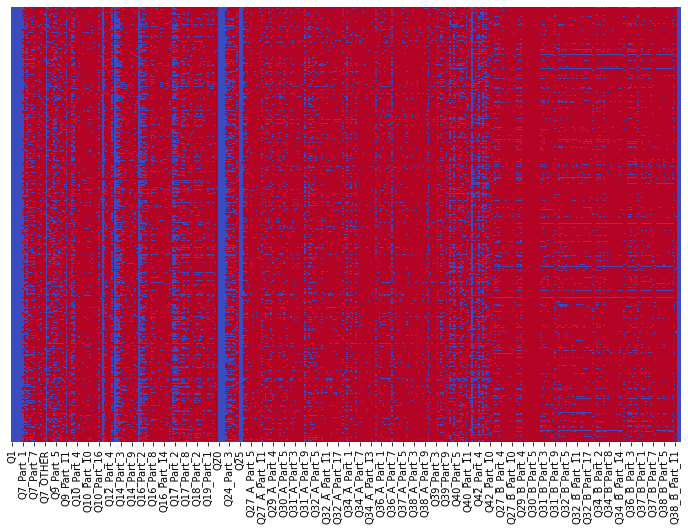

In [8]:
fig, ax = plt.subplots(figsize=(12,8))
sns.heatmap(df.isnull(), cmap='coolwarm', yticklabels=False, cbar=False, ax=ax)

As shown, there are many columns that have null values, therefore I have to either:
- drop the columns
- replace the missing values
- drop some rows

In [9]:
df.columns

Index(['Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6', 'Q7_Part_1', 'Q7_Part_2',
       'Q7_Part_3', 'Q7_Part_4',
       ...
       'Q38_B_Part_5', 'Q38_B_Part_6', 'Q38_B_Part_7', 'Q38_B_Part_8',
       'Q38_B_Part_9', 'Q38_B_Part_10', 'Q38_B_Part_11', 'Q38_B_OTHER',
       'Q25_Encoded', 'Q25_buckets'],
      dtype='object', length=370)

Upon looking at the columns of the data frame, I noticed a pattern with some questions in the survey, so I investigated it further in the following steps:

In [10]:
df2= pd.read_csv('clean_kaggle_data_2021.csv')
list(df2.loc[0][7:20])

['What programming languages do you use on a regular basis? (Select all that apply) - Selected Choice - Python',
 'What programming languages do you use on a regular basis? (Select all that apply) - Selected Choice - R',
 'What programming languages do you use on a regular basis? (Select all that apply) - Selected Choice - SQL',
 'What programming languages do you use on a regular basis? (Select all that apply) - Selected Choice - C',
 'What programming languages do you use on a regular basis? (Select all that apply) - Selected Choice - C++',
 'What programming languages do you use on a regular basis? (Select all that apply) - Selected Choice - Java',
 'What programming languages do you use on a regular basis? (Select all that apply) - Selected Choice - Javascript',
 'What programming languages do you use on a regular basis? (Select all that apply) - Selected Choice - Julia',
 'What programming languages do you use on a regular basis? (Select all that apply) - Selected Choice - Swift',

Notice, there are Q7_Part_1, Q7_Part_2... After inspecting the questions on those different columns (all parts under the same question), I noticed that the question was the same, e.g., What programming languages do you use on a regular basis? (Select all that apply) - Selected Choice, however, what is different is the type of programming language used. If a participant knows Python but none of the rest, they will leave the other columns empty. For this reason, I will replace the null values in those columns with zeros (I will do the same for the other columns with several parts). Also, if a participant leaves all of them empty, an assumption I will make is that they do not know any of the programs. For this reason, and because that this is similar to the concept of one hot encoding, we can drop the None column in all the questions having several parts. If the other columns are empty, it will be automatically assumed that it is None (they do not know any of the programs).

The following code shows us which columns have several parts and drops the "None" columns. This will allow us to replace the Nan in the questions with zeros.

Finding the Encoded Features:

In [11]:
onehot_columns=np.array(df.columns.copy())
column_names=[]

for i in range(1,43):
    column_names.append('Q'+str(i))

for i in column_names:
    if i in df.columns:
        onehot_columns=np.delete(onehot_columns, np.where(onehot_columns==i)[0][0])
    
onehot_columns=np.delete(onehot_columns, [len(onehot_columns)-2,len(onehot_columns)-1])
onehot_columns

array(['Q7_Part_1', 'Q7_Part_2', 'Q7_Part_3', 'Q7_Part_4', 'Q7_Part_5',
       'Q7_Part_6', 'Q7_Part_7', 'Q7_Part_8', 'Q7_Part_9', 'Q7_Part_10',
       'Q7_Part_11', 'Q7_Part_12', 'Q7_OTHER', 'Q9_Part_1', 'Q9_Part_2',
       'Q9_Part_3', 'Q9_Part_4', 'Q9_Part_5', 'Q9_Part_6', 'Q9_Part_7',
       'Q9_Part_8', 'Q9_Part_9', 'Q9_Part_10', 'Q9_Part_11', 'Q9_Part_12',
       'Q9_OTHER', 'Q10_Part_1', 'Q10_Part_2', 'Q10_Part_3', 'Q10_Part_4',
       'Q10_Part_5', 'Q10_Part_6', 'Q10_Part_7', 'Q10_Part_8',
       'Q10_Part_9', 'Q10_Part_10', 'Q10_Part_11', 'Q10_Part_12',
       'Q10_Part_13', 'Q10_Part_14', 'Q10_Part_15', 'Q10_Part_16',
       'Q10_OTHER', 'Q12_Part_1', 'Q12_Part_2', 'Q12_Part_3',
       'Q12_Part_4', 'Q12_Part_5', 'Q12_OTHER', 'Q14_Part_1',
       'Q14_Part_2', 'Q14_Part_3', 'Q14_Part_4', 'Q14_Part_5',
       'Q14_Part_6', 'Q14_Part_7', 'Q14_Part_8', 'Q14_Part_9',
       'Q14_Part_10', 'Q14_Part_11', 'Q14_OTHER', 'Q16_Part_1',
       'Q16_Part_2', 'Q16_Part_3', 'Q16_Part_4', '

Here we are filling the empty values with zeros and the characters with ones. We are making the columns binary to show that if the participant has selected the option, it will be set to 1, if they have not selected the option, it will be set to 0.

In [12]:
df[onehot_columns]=df[onehot_columns].fillna(0)
df[onehot_columns]=(df[onehot_columns]!=0).astype(int)
df[onehot_columns]

,Q7_Part_1,Q7_Part_2,Q7_Part_3,Q7_Part_4,Q7_Part_5,Q7_Part_6,Q7_Part_7,Q7_Part_8,Q7_Part_9,Q7_Part_10,...,Q38_B_Part_3,Q38_B_Part_4,Q38_B_Part_5,Q38_B_Part_6,Q38_B_Part_7,Q38_B_Part_8,Q38_B_Part_9,Q38_B_Part_10,Q38_B_Part_11,Q38_B_OTHER
1,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,1,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,1,0,0,0,1,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
5,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15387,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
15388,1,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
15389,1,0,1,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
15390,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


I noticed that most columns that are encoded have the option None, except for one, which phrases the word none in a different way, so I will be dropping both those options to remove the redundancy of information. The idea here is that if none of the options are selected it is automatically understood that the option is none of them.

In [13]:
new_columns=[]

for i in range (len(df2.columns)):
    if df2.loc[0].notnull()[i]==1:
        if ('None' not in df2.loc[0].iloc[i]) & ("I do not share my work publicly" not in df2.loc[0].iloc[i]):
            new_columns.append(df2.columns[i])
    else:
        new_columns.append(df2.columns[i])
            
del new_columns[0]

In [14]:
df=df[new_columns]
df

,Q1,Q2,Q3,Q4,Q5,Q6,Q7_Part_1,Q7_Part_2,Q7_Part_3,Q7_Part_4,...,Q38_B_Part_4,Q38_B_Part_5,Q38_B_Part_6,Q38_B_Part_7,Q38_B_Part_8,Q38_B_Part_9,Q38_B_Part_10,Q38_B_OTHER,Q25_Encoded,Q25_buckets
1,50-54,Man,India,Bachelor’s degree,Other,5-10 years,1,1,0,0,...,0,0,0,0,0,0,0,0,2.0,"20,000-29,999"
2,50-54,Man,Indonesia,Master’s degree,Program/Project Manager,20+ years,0,0,1,1,...,0,0,0,0,0,0,0,0,6.0,"60,000-69,999"
3,22-24,Man,Pakistan,Master’s degree,Software Engineer,1-3 years,1,0,0,0,...,0,1,0,0,0,0,0,0,0.0,"0-9,999"
4,45-49,Man,Mexico,Doctoral degree,Research Scientist,20+ years,1,0,0,0,...,0,0,0,0,0,0,0,0,3.0,"30,000-39,999"
5,45-49,Man,India,Doctoral degree,Other,< 1 years,1,0,0,1,...,0,0,0,0,0,0,0,0,3.0,"30,000-39,999"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15387,30-34,Man,India,Bachelor’s degree,Data Analyst,1-3 years,1,0,0,1,...,0,0,0,0,0,0,0,0,0.0,"0-9,999"
15388,35-39,Man,South Korea,Bachelor’s degree,Software Engineer,5-10 years,1,0,1,0,...,0,0,0,0,0,0,0,0,8.0,"80,000-89,999"
15389,30-34,Man,Egypt,Bachelor’s degree,Data Analyst,1-3 years,1,0,1,0,...,0,0,0,0,0,0,0,0,1.0,"10,000-19,999"
15390,50-54,Man,Sweden,Doctoral degree,Research Scientist,I have never written code,0,0,0,0,...,0,0,0,0,0,0,0,0,0.0,"0-9,999"


Now that the encoded columns have been cleaned, let us look at the other columns containing null values.

In [15]:
df.columns[df.isnull().any()]

Index(['Q8', 'Q11', 'Q13', 'Q15', 'Q26', 'Q28', 'Q33', 'Q35', 'Q41'], dtype='object')

Let us see what the questions are in the columns to know how to fill them:

In [16]:
for i in df.columns[df.isnull().any()]:
    print(i,":", df2.loc[0][i])
    print("\n")

Q8 : What programming language would you recommend an aspiring data scientist to learn first? - Selected Choice


Q11 : What type of computing platform do you use most often for your data science projects? - Selected Choice


Q13 : Approximately how many times have you used a TPU (tensor processing unit)?


Q15 : For how many years have you used machine learning methods?


Q26 : Approximately how much money have you (or your team) spent on machine learning and/or cloud computing services at home (or at work) in the past 5 years (approximate $USD)?


Q28 : Of the cloud platforms that you are familiar with, which has the best developer experience (most enjoyable to use)? - Selected Choice


Q33 : Which of the following big data products (relational database, data warehouse, data lake, or similar) do you use most often? - Selected Choice


Q35 : Which of the following business intelligence tools do you use most often? - Selected Choice


Q41 : What is the primary tool that you use at work

Looking at Q8, this is an advice question rather than a question that allows us to know more about the participants' knowledge and skill. Therefore dropping it will likely not impact the predictions of the salary of the participant.

In [17]:
df=df.drop(['Q8'],axis=1)
df

,Q1,Q2,Q3,Q4,Q5,Q6,Q7_Part_1,Q7_Part_2,Q7_Part_3,Q7_Part_4,...,Q38_B_Part_4,Q38_B_Part_5,Q38_B_Part_6,Q38_B_Part_7,Q38_B_Part_8,Q38_B_Part_9,Q38_B_Part_10,Q38_B_OTHER,Q25_Encoded,Q25_buckets
1,50-54,Man,India,Bachelor’s degree,Other,5-10 years,1,1,0,0,...,0,0,0,0,0,0,0,0,2.0,"20,000-29,999"
2,50-54,Man,Indonesia,Master’s degree,Program/Project Manager,20+ years,0,0,1,1,...,0,0,0,0,0,0,0,0,6.0,"60,000-69,999"
3,22-24,Man,Pakistan,Master’s degree,Software Engineer,1-3 years,1,0,0,0,...,0,1,0,0,0,0,0,0,0.0,"0-9,999"
4,45-49,Man,Mexico,Doctoral degree,Research Scientist,20+ years,1,0,0,0,...,0,0,0,0,0,0,0,0,3.0,"30,000-39,999"
5,45-49,Man,India,Doctoral degree,Other,< 1 years,1,0,0,1,...,0,0,0,0,0,0,0,0,3.0,"30,000-39,999"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15387,30-34,Man,India,Bachelor’s degree,Data Analyst,1-3 years,1,0,0,1,...,0,0,0,0,0,0,0,0,0.0,"0-9,999"
15388,35-39,Man,South Korea,Bachelor’s degree,Software Engineer,5-10 years,1,0,1,0,...,0,0,0,0,0,0,0,0,8.0,"80,000-89,999"
15389,30-34,Man,Egypt,Bachelor’s degree,Data Analyst,1-3 years,1,0,1,0,...,0,0,0,0,0,0,0,0,1.0,"10,000-19,999"
15390,50-54,Man,Sweden,Doctoral degree,Research Scientist,I have never written code,0,0,0,0,...,0,0,0,0,0,0,0,0,0.0,"0-9,999"


In [18]:
df.isnull().sum()[df.isnull().sum()!=0]

Q11      961
Q13      961
Q15      961
Q26      208
Q28    12264
Q33    10735
Q35    13154
Q41     1965
dtype: int64

Looking at the article, https://towardsdatascience.com/7-ways-to-handle-missing-values-in-machine-learning-1a6326adf79e, if we have some features with missing values exceeding a large percentage of the data, then the best thing is to remove the column. I will assume that threshold is 10%.

In [19]:
dropping_columns=[]
for i in range (len(df.isnull().sum()[df.isnull().sum()!=0])):
    if (df.isnull().sum()[df.isnull().sum()!=0]/len(df)).values[i]>0.1:
        dropping_columns.append(df.isnull().sum()[df.isnull().sum()!=0].index[i])
        
print("The columns that will be dropped are", dropping_columns)

The columns that will be dropped are ['Q28', 'Q33', 'Q35', 'Q41']


In [20]:
df=df.drop(dropping_columns,axis=1)
df

,Q1,Q2,Q3,Q4,Q5,Q6,Q7_Part_1,Q7_Part_2,Q7_Part_3,Q7_Part_4,...,Q38_B_Part_4,Q38_B_Part_5,Q38_B_Part_6,Q38_B_Part_7,Q38_B_Part_8,Q38_B_Part_9,Q38_B_Part_10,Q38_B_OTHER,Q25_Encoded,Q25_buckets
1,50-54,Man,India,Bachelor’s degree,Other,5-10 years,1,1,0,0,...,0,0,0,0,0,0,0,0,2.0,"20,000-29,999"
2,50-54,Man,Indonesia,Master’s degree,Program/Project Manager,20+ years,0,0,1,1,...,0,0,0,0,0,0,0,0,6.0,"60,000-69,999"
3,22-24,Man,Pakistan,Master’s degree,Software Engineer,1-3 years,1,0,0,0,...,0,1,0,0,0,0,0,0,0.0,"0-9,999"
4,45-49,Man,Mexico,Doctoral degree,Research Scientist,20+ years,1,0,0,0,...,0,0,0,0,0,0,0,0,3.0,"30,000-39,999"
5,45-49,Man,India,Doctoral degree,Other,< 1 years,1,0,0,1,...,0,0,0,0,0,0,0,0,3.0,"30,000-39,999"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15387,30-34,Man,India,Bachelor’s degree,Data Analyst,1-3 years,1,0,0,1,...,0,0,0,0,0,0,0,0,0.0,"0-9,999"
15388,35-39,Man,South Korea,Bachelor’s degree,Software Engineer,5-10 years,1,0,1,0,...,0,0,0,0,0,0,0,0,8.0,"80,000-89,999"
15389,30-34,Man,Egypt,Bachelor’s degree,Data Analyst,1-3 years,1,0,1,0,...,0,0,0,0,0,0,0,0,1.0,"10,000-19,999"
15390,50-54,Man,Sweden,Doctoral degree,Research Scientist,I have never written code,0,0,0,0,...,0,0,0,0,0,0,0,0,0.0,"0-9,999"


In [21]:
df.isnull().sum()[df.isnull().sum()!=0]

Q11    961
Q13    961
Q15    961
Q26    208
dtype: int64

Now let us look at the remaining columns:

### Manually Cleaning Remaining Columns

#### Q11: What type of computing platform do you use most often for your data science projects? - Selected Choice

I started by looking at all the values in the column, and their frequencies.

In [22]:
df['Q11'].value_counts()

A laptop                                                               8771
A personal computer / desktop                                          3095
A cloud computing platform (AWS, Azure, GCP, hosted notebooks, etc)    1705
A deep learning workstation (NVIDIA GTX, LambdaLabs, etc)               593
None                                                                    144
Other                                                                   122
Name: Q11, dtype: int64

(array([0, 1, 2, 3, 4, 5]),
 [Text(0, 0, 'A laptop'),
  Text(1, 0, 'A cloud computing platform (AWS, Azure, GCP, hosted notebooks, etc)'),
  Text(2, 0, 'A personal computer / desktop'),
  Text(3, 0, 'A deep learning workstation (NVIDIA GTX, LambdaLabs, etc)'),
  Text(4, 0, 'Other'),
  Text(5, 0, 'None')])

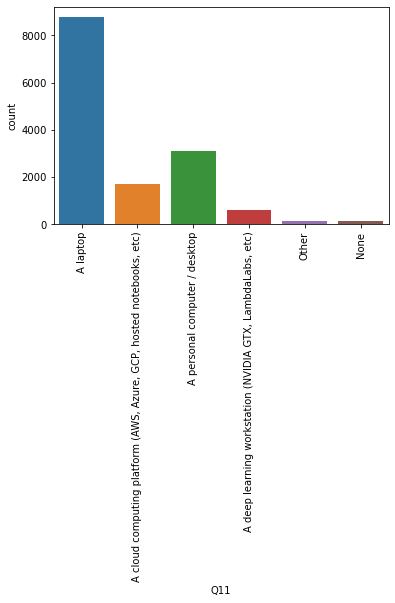

In [23]:
sns.countplot(x='Q11', data=df)
plt.xticks(rotation=90)

I will look at how in each salary bucket the most prominent platform used. If "A laptop is the mode in all of them, we will replace the missing values in that column with A laptop".

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 [Text(0, 0, '20,000-29,999'),
  Text(1, 0, '60,000-69,999'),
  Text(2, 0, '0-9,999'),
  Text(3, 0, '30,000-39,999'),
  Text(4, 0, '10,000-19,999'),
  Text(5, 0, '70,000-79,999'),
  Text(6, 0, '100,000-124,999'),
  Text(7, 0, '40,000-49,999'),
  Text(8, 0, '50,000-59,999'),
  Text(9, 0, '>300,000'),
  Text(10, 0, '200,000-299,999'),
  Text(11, 0, '125,000-149,999'),
  Text(12, 0, '80,000-89,999'),
  Text(13, 0, '90,000-99,999'),
  Text(14, 0, '150,000-199,999')])

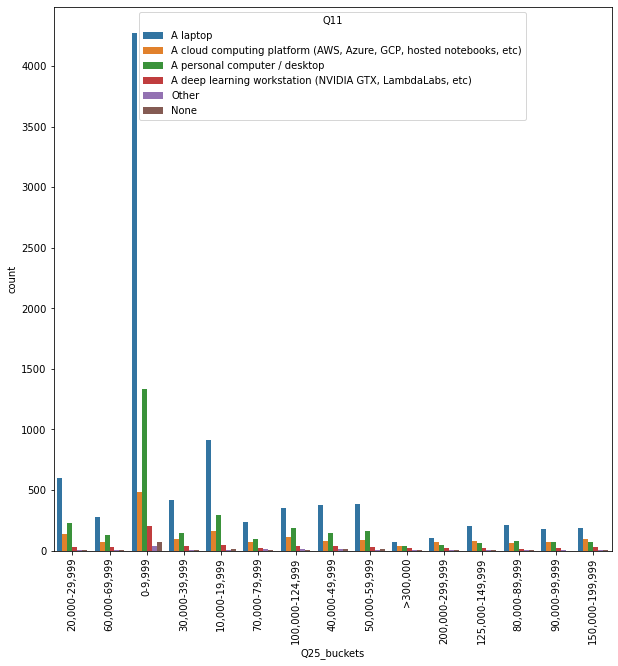

In [24]:
plt.figure(figsize=(10,10))
sns.countplot(x='Q25_buckets', hue='Q11', data=df)
plt.xticks(rotation=90)

We can see that the majority in all the buckets use their laptops for data science projects. Therefore, I will replace all Nan values in the Q11 column with "A laptop".

In [25]:
df['Q11']=df['Q11'].fillna("A laptop")

#### Q13: Approximately how many times have you used a TPU (tensor processing unit)?

Following the same procedure as before, if the same value is found in all buckets, I will replace the missing values with the mode of the column.

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 [Text(0, 0, '20,000-29,999'),
  Text(1, 0, '60,000-69,999'),
  Text(2, 0, '0-9,999'),
  Text(3, 0, '30,000-39,999'),
  Text(4, 0, '10,000-19,999'),
  Text(5, 0, '70,000-79,999'),
  Text(6, 0, '100,000-124,999'),
  Text(7, 0, '40,000-49,999'),
  Text(8, 0, '50,000-59,999'),
  Text(9, 0, '>300,000'),
  Text(10, 0, '200,000-299,999'),
  Text(11, 0, '125,000-149,999'),
  Text(12, 0, '80,000-89,999'),
  Text(13, 0, '90,000-99,999'),
  Text(14, 0, '150,000-199,999')])

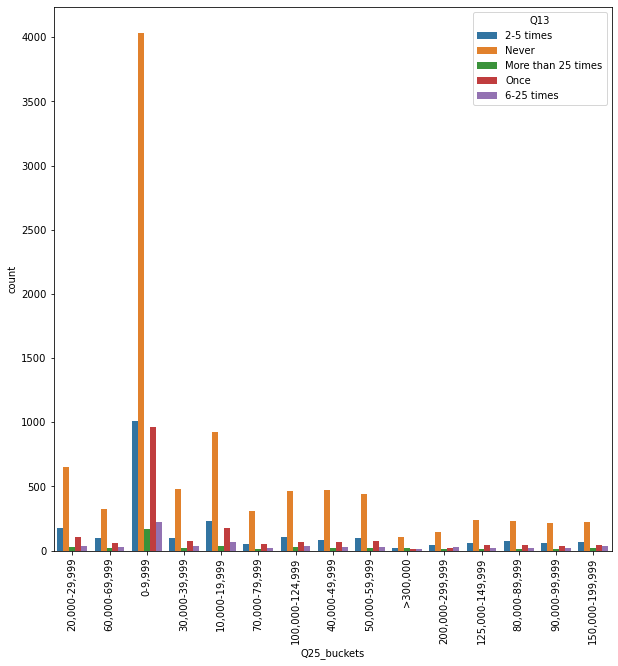

In [26]:
plt.figure(figsize=(10,10))
sns.countplot(x='Q25_buckets', hue='Q13', data=df)
plt.xticks(rotation=90)

Never is the most prominent value. Additionally, after looking at the columns in df, I noticed that column Q12 part 2 asks the participants if they used Google Cloud TPUs. I will see if all the Nan values in Q13 correspond to people who responded 0 for question Q12 part 2. If they all check, I will simply replace the Nan values in Q13 with Never (also taking into account the above plot).

In [27]:
df[(df['Q12_Part_2']==0) & (df["Q13"].isnull())]

,Q1,Q2,Q3,Q4,Q5,Q6,Q7_Part_1,Q7_Part_2,Q7_Part_3,Q7_Part_4,...,Q38_B_Part_4,Q38_B_Part_5,Q38_B_Part_6,Q38_B_Part_7,Q38_B_Part_8,Q38_B_Part_9,Q38_B_Part_10,Q38_B_OTHER,Q25_Encoded,Q25_buckets
118,30-34,Man,United States of America,Master’s degree,Business Analyst,I have never written code,0,0,0,0,...,0,0,0,0,0,0,0,0,10.0,"100,000-124,999"
119,40-44,Man,Japan,Bachelor’s degree,Business Analyst,I have never written code,0,0,0,0,...,0,0,0,0,0,0,0,0,7.0,"70,000-79,999"
159,35-39,Man,Indonesia,No formal education past high school,Data Scientist,I have never written code,0,0,0,0,...,0,0,0,0,0,0,0,0,0.0,"0-9,999"
176,22-24,Woman,India,Master’s degree,Research Scientist,I have never written code,0,0,0,0,...,0,0,0,0,0,0,0,0,0.0,"0-9,999"
179,30-34,Woman,United States of America,Master’s degree,Data Engineer,I have never written code,0,0,0,0,...,0,1,0,1,0,0,0,0,0.0,"0-9,999"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15273,30-34,Woman,United States of America,Professional doctorate,Other,I have never written code,0,0,0,0,...,0,0,0,0,0,0,0,0,5.0,"50,000-59,999"
15339,18-21,Woman,United Kingdom of Great Britain and Northern I...,Bachelor’s degree,Other,I have never written code,0,0,0,0,...,0,0,0,0,0,0,0,0,0.0,"0-9,999"
15353,30-34,Man,Other,Some college/university study without earning ...,Other,I have never written code,0,0,0,0,...,0,0,0,0,0,0,0,0,1.0,"10,000-19,999"
15390,50-54,Man,Sweden,Doctoral degree,Research Scientist,I have never written code,0,0,0,0,...,0,0,0,0,0,0,0,0,0.0,"0-9,999"


In [28]:
df['Q13']=df['Q13'].fillna("Never")

#### Q15: For how many years have you used machine learning methods?

An assumption that can be made is that the number of years a participant has used machine learning methods in depends on their age. I will be plotting the relationship between those two to check if for every age, the missing values should be filled differently for the number of years they have been using machine learning methods.

In [29]:
age_experience=df[['Q1', 'Q15','Q25_Encoded']]
age_experience.groupby(['Q1','Q15']).count()

Q25_Encoded
Q1    Q15                                               
18-21 1-2 years                                      235
      10-20 years                                      1
      2-3 years                                       59
      3-4 years                                       13
      4-5 years                                        9
...                                                  ...
70+   3-4 years                                        4
      4-5 years                                        6
      5-10 years                                       8
      I do not use machine learning methods           19
      Under 1 year                                    21

[95 rows x 1 columns]

In [30]:
columns_new=np.array(age_experience.groupby(['Q1','Q15']).count().loc['70+'].index)
values=[]
for i in age_experience.groupby('Q1').count().index:
    for j in columns_new:
        try:
            values.append(int(age_experience.groupby(['Q1','Q15']).count().loc[i].loc[j].values))
        except:
            values.append(0)
values=np.array(values).reshape(-1,9)
age_experience_df=pd.DataFrame(values, columns=columns_new, index=age_experience.groupby('Q1').count().index)
age_experience_df['Null']=age_experience[age_experience['Q15'].isnull()].groupby('Q1').count()['Q25_Encoded']
age_experience_df=age_experience_df[['I do not use machine learning methods', 'Under 1 year', '1-2 years','2-3 years', '3-4 years', '4-5 years', '5-10 years', '10-20 years', '20 or more years', 'Null']]
age_experience_df=age_experience_df.transpose()
age_experience_df

Q1,18-21,22-24,25-29,30-34,35-39,40-44,45-49,50-54,55-59,60-69,70+
I do not use machine learning methods,122,259,399,306,246,182,129,94,64,47,19
Under 1 year,421,801,1009,747,522,377,265,163,105,83,21
1-2 years,235,576,701,438,326,231,203,126,56,69,9
2-3 years,59,251,445,288,210,185,134,96,50,55,11
3-4 years,13,75,246,198,138,107,78,45,34,29,4
4-5 years,9,25,156,195,131,109,75,62,37,40,6
5-10 years,2,3,88,245,194,151,90,70,60,49,8
10-20 years,1,0,0,19,80,85,58,46,25,23,2
20 or more years,0,1,0,2,5,14,36,37,42,34,13
Null,69,101,191,188,140,87,73,52,31,25,4


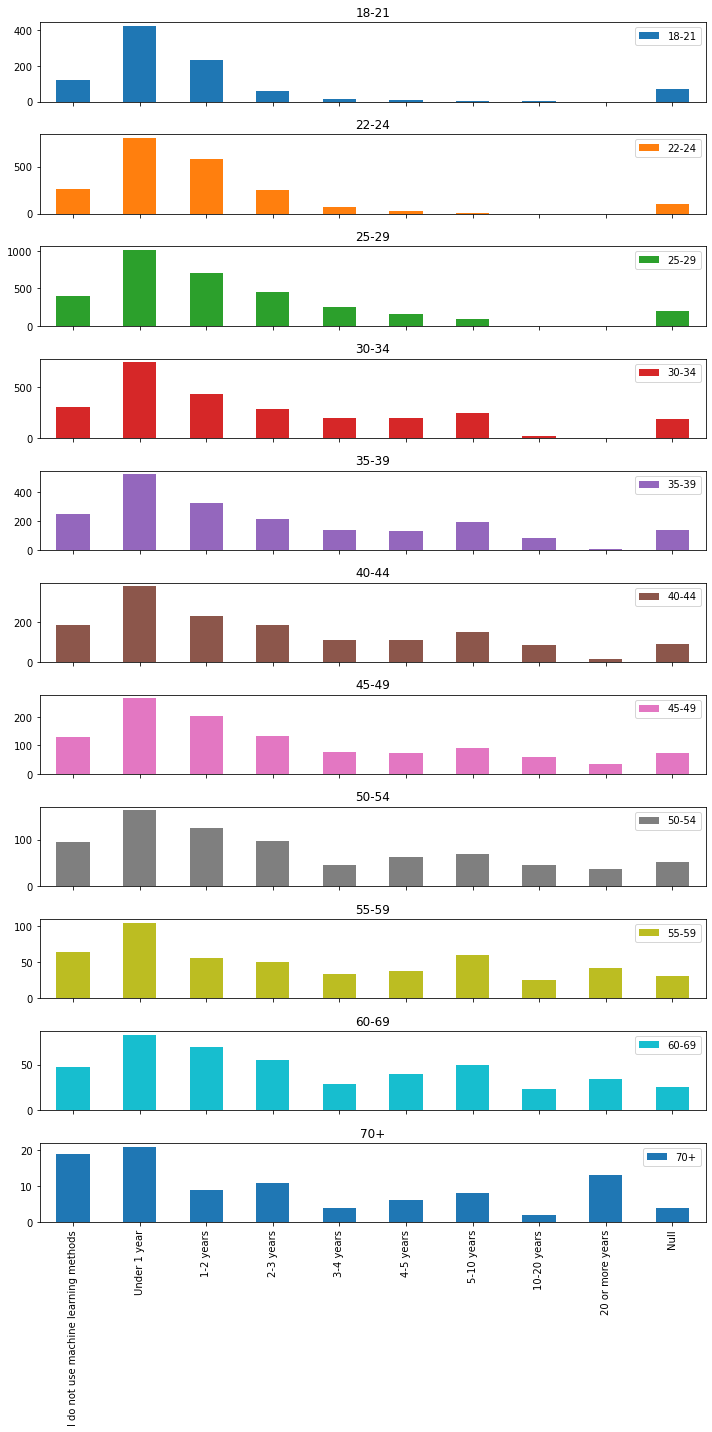

In [31]:
age_experience_df.plot.bar(subplots=True, figsize=(10,20), sharex=True)
plt.tight_layout()

Although I expected that the older the participants is, the higher the number of years in which they used machine learning techniques. However, it seems that for all age categories, it is best to replace Nan values with Under 1 year.

In [32]:
df['Q15']=df['Q15'].fillna("Under 1 year")
df

,Q1,Q2,Q3,Q4,Q5,Q6,Q7_Part_1,Q7_Part_2,Q7_Part_3,Q7_Part_4,...,Q38_B_Part_4,Q38_B_Part_5,Q38_B_Part_6,Q38_B_Part_7,Q38_B_Part_8,Q38_B_Part_9,Q38_B_Part_10,Q38_B_OTHER,Q25_Encoded,Q25_buckets
1,50-54,Man,India,Bachelor’s degree,Other,5-10 years,1,1,0,0,...,0,0,0,0,0,0,0,0,2.0,"20,000-29,999"
2,50-54,Man,Indonesia,Master’s degree,Program/Project Manager,20+ years,0,0,1,1,...,0,0,0,0,0,0,0,0,6.0,"60,000-69,999"
3,22-24,Man,Pakistan,Master’s degree,Software Engineer,1-3 years,1,0,0,0,...,0,1,0,0,0,0,0,0,0.0,"0-9,999"
4,45-49,Man,Mexico,Doctoral degree,Research Scientist,20+ years,1,0,0,0,...,0,0,0,0,0,0,0,0,3.0,"30,000-39,999"
5,45-49,Man,India,Doctoral degree,Other,< 1 years,1,0,0,1,...,0,0,0,0,0,0,0,0,3.0,"30,000-39,999"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15387,30-34,Man,India,Bachelor’s degree,Data Analyst,1-3 years,1,0,0,1,...,0,0,0,0,0,0,0,0,0.0,"0-9,999"
15388,35-39,Man,South Korea,Bachelor’s degree,Software Engineer,5-10 years,1,0,1,0,...,0,0,0,0,0,0,0,0,8.0,"80,000-89,999"
15389,30-34,Man,Egypt,Bachelor’s degree,Data Analyst,1-3 years,1,0,1,0,...,0,0,0,0,0,0,0,0,1.0,"10,000-19,999"
15390,50-54,Man,Sweden,Doctoral degree,Research Scientist,I have never written code,0,0,0,0,...,0,0,0,0,0,0,0,0,0.0,"0-9,999"


#### Q26: Approximately how much money have you (or your team) spent on machine learning and/or cloud computing services at home (or at work) in the past 5 years (approximate $USD)?

I wanted to check if the years of experience changed the mode value of Q26, and see if participants with different numbers of years of experience should be filled differently.

In [33]:
age_money=df[['Q6', 'Q26','Q25_Encoded']]
age_money.groupby(['Q6','Q26']).count()

Q25_Encoded
Q6                        Q26                                 
1-3 years                 $0 ($USD)                       1525
                          $1-$99                           557
                          $10,000-$99,999                  231
                          $100,000 or more ($USD)          117
                          $100-$999                        670
                          $1000-$9,999                     528
10-20 years               $0 ($USD)                        515
                          $1-$99                           177
                          $10,000-$99,999                  243
                          $100,000 or more ($USD)          210
                          $100-$999                        313
                          $1000-$9,999                     372
20+ years                 $0 ($USD)                        492
                          $1-$99                           114
                          $10,000-$99,999                  226
                          $100,000 or more ($USD)          226
                          $100-$999                        227
                          $1000-$9,999                     322
3-5 years                 $0 ($USD)                        834
                          $1-$99                           339
                          $10,000-$99,999                  219
                          $100,000 or more ($USD)          157
                          $100-$999                        427
                          $1000-$9,999                     445
5-10 years                $0 ($USD)                        719
                          $1-$99                           236
                          $10,000-$99,999                  274
                          $100,000 or more ($USD)          219
                          $100-$999                        399
                          $1000-$9,999                     474
< 1 years                 $0 ($USD)                       1260
                          $1-$99                           393
                          $10,000-$99,999                   79
                          $100,000 or more ($USD)           54
                          $100-$999                        382
                          $1000-$9,999                     251
I have never written code $0 ($USD)                        558
                          $1-$99                           113
                          $10,000-$99,999                   37
                          $100,000 or more ($USD)           34
                          $100-$999                        116
                          $1000-$9,999                      99

In [34]:
columns_new2=np.array(age_money.groupby(['Q6','Q26']).count().loc['1-3 years'].index)
values2=[]
for i in age_money.groupby('Q6').count().index:
    for j in columns_new2:
        try:
            values2.append(int(age_money.groupby(['Q6','Q26']).count().loc[i].loc[j].values))
        except:
            values2.append(0)
values2=np.array(values2).reshape(-1,6)
age_money_df=pd.DataFrame(values2, columns=columns_new2, index=age_money.groupby('Q6').count().index)
age_money_df['Null']=age_money[age_money['Q26'].isnull()].groupby('Q6').count()['Q25_Encoded']
age_money_df=age_money_df[['$0 ($USD)', '$1-$99', '$100-$999','$1000-$9,999', '$10,000-$99,999', '$100,000 or more ($USD)', 'Null']]
age_money_df=age_money_df.transpose()
age_money_df

Q6,1-3 years,10-20 years,20+ years,3-5 years,5-10 years,< 1 years,I have never written code
$0 ($USD),1525,515,492,834,719,1260,558
$1-$99,557,177,114,339,236,393,113
$100-$999,670,313,227,427,399,382,116
"$1000-$9,999",528,372,322,445,474,251,99
"$10,000-$99,999",231,243,226,219,274,79,37
"$100,000 or more ($USD)",117,210,226,157,219,54,34
Null,63,16,17,40,24,44,4


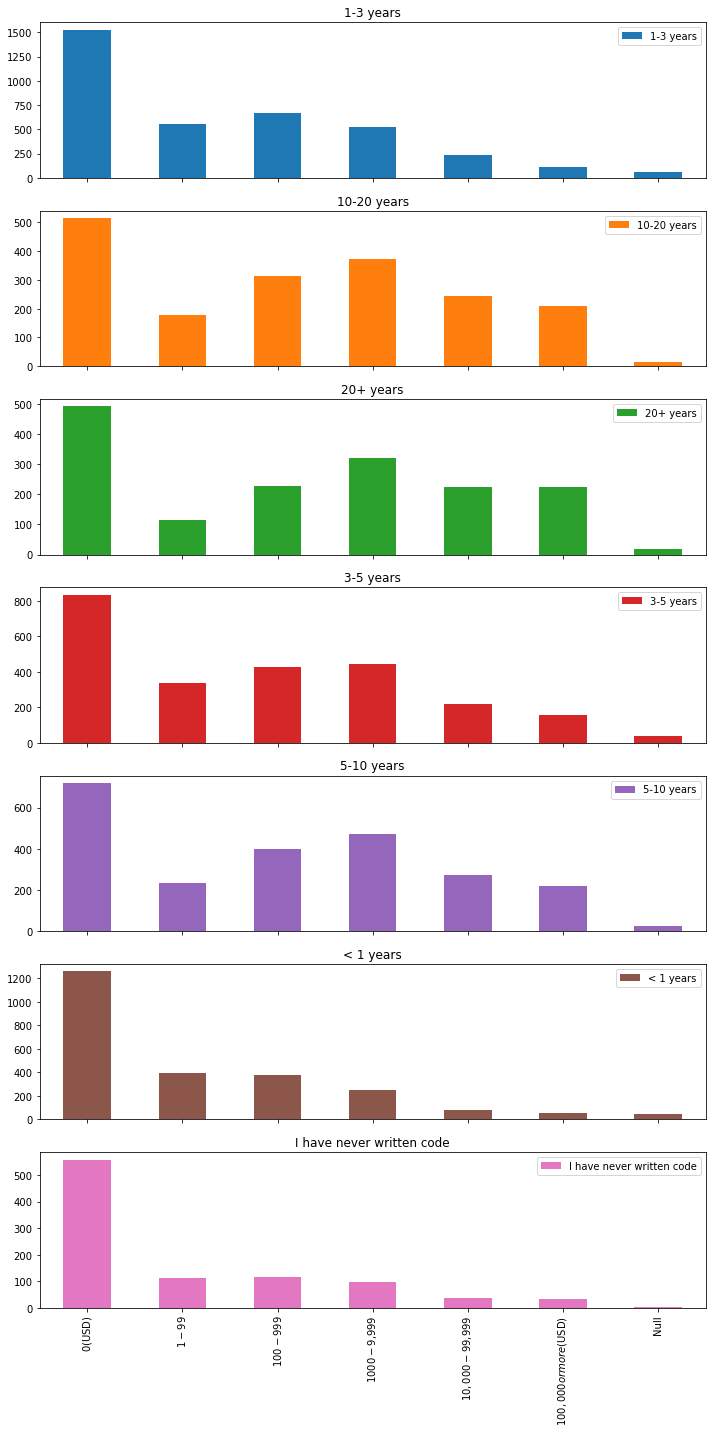

In [35]:
age_money_df.plot.bar(subplots=True, figsize=(10,20), sharex=True)
plt.tight_layout()

Seeing how they all have the same mode, I will replace all the null values with 0(USD).

In [36]:
df['Q26']=df['Q26'].fillna("$0 ($USD)")
df

,Q1,Q2,Q3,Q4,Q5,Q6,Q7_Part_1,Q7_Part_2,Q7_Part_3,Q7_Part_4,...,Q38_B_Part_4,Q38_B_Part_5,Q38_B_Part_6,Q38_B_Part_7,Q38_B_Part_8,Q38_B_Part_9,Q38_B_Part_10,Q38_B_OTHER,Q25_Encoded,Q25_buckets
1,50-54,Man,India,Bachelor’s degree,Other,5-10 years,1,1,0,0,...,0,0,0,0,0,0,0,0,2.0,"20,000-29,999"
2,50-54,Man,Indonesia,Master’s degree,Program/Project Manager,20+ years,0,0,1,1,...,0,0,0,0,0,0,0,0,6.0,"60,000-69,999"
3,22-24,Man,Pakistan,Master’s degree,Software Engineer,1-3 years,1,0,0,0,...,0,1,0,0,0,0,0,0,0.0,"0-9,999"
4,45-49,Man,Mexico,Doctoral degree,Research Scientist,20+ years,1,0,0,0,...,0,0,0,0,0,0,0,0,3.0,"30,000-39,999"
5,45-49,Man,India,Doctoral degree,Other,< 1 years,1,0,0,1,...,0,0,0,0,0,0,0,0,3.0,"30,000-39,999"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15387,30-34,Man,India,Bachelor’s degree,Data Analyst,1-3 years,1,0,0,1,...,0,0,0,0,0,0,0,0,0.0,"0-9,999"
15388,35-39,Man,South Korea,Bachelor’s degree,Software Engineer,5-10 years,1,0,1,0,...,0,0,0,0,0,0,0,0,8.0,"80,000-89,999"
15389,30-34,Man,Egypt,Bachelor’s degree,Data Analyst,1-3 years,1,0,1,0,...,0,0,0,0,0,0,0,0,1.0,"10,000-19,999"
15390,50-54,Man,Sweden,Doctoral degree,Research Scientist,I have never written code,0,0,0,0,...,0,0,0,0,0,0,0,0,0.0,"0-9,999"


Now that all the missing values have been filled, let us plot the heatmap again and check.

<AxesSubplot:>

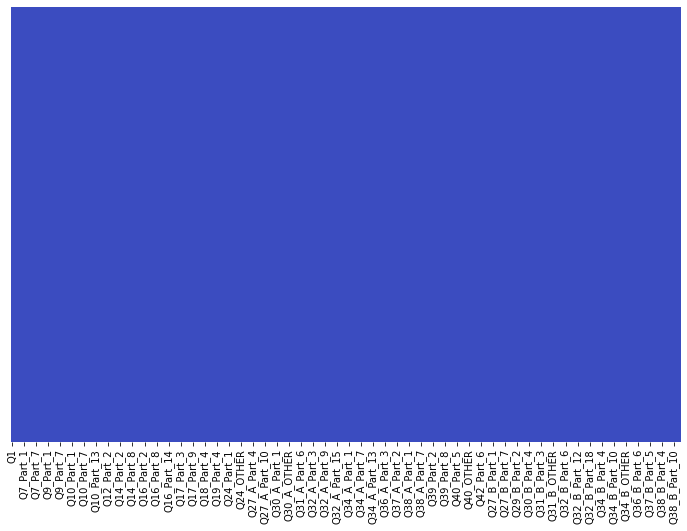

In [37]:
fig, ax = plt.subplots(figsize=(12,8))
sns.heatmap(df.isnull(), cmap='coolwarm', yticklabels=False, cbar=False, ax=ax)

Now, we need to encode our data, whether through converting the categorical features into numerical numbers (assuming there is an ordered relationship), or through creating dummy variables.

Let us check the non encoded data.

In [38]:
col_to_encode=[]
for i in column_names:
    if i in df.columns:
        col_to_encode.append(i)
        
del col_to_encode[-2]
col_to_encode

['Q1',
 'Q2',
 'Q3',
 'Q4',
 'Q5',
 'Q6',
 'Q11',
 'Q13',
 'Q15',
 'Q20',
 'Q21',
 'Q22',
 'Q23',
 'Q26']

In [39]:
df[col_to_encode]

,Q1,Q2,Q3,Q4,Q5,Q6,Q11,Q13,Q15,Q20,Q21,Q22,Q23,Q26
1,50-54,Man,India,Bachelor’s degree,Other,5-10 years,A laptop,2-5 times,5-10 years,Manufacturing/Fabrication,50-249 employees,3-4,No (we do not use ML methods),$100-$999
2,50-54,Man,Indonesia,Master’s degree,Program/Project Manager,20+ years,"A cloud computing platform (AWS, Azure, GCP, h...",Never,Under 1 year,Manufacturing/Fabrication,"1000-9,999 employees",1-2,We are exploring ML methods (and may one day p...,$0 ($USD)
3,22-24,Man,Pakistan,Master’s degree,Software Engineer,1-3 years,A laptop,Never,I do not use machine learning methods,Academics/Education,"1000-9,999 employees",0,I do not know,$0 ($USD)
4,45-49,Man,Mexico,Doctoral degree,Research Scientist,20+ years,"A cloud computing platform (AWS, Azure, GCP, h...",More than 25 times,5-10 years,Academics/Education,"1000-9,999 employees",0,I do not know,$0 ($USD)
5,45-49,Man,India,Doctoral degree,Other,< 1 years,"A cloud computing platform (AWS, Azure, GCP, h...",Never,10-20 years,Academics/Education,50-249 employees,5-9,We use ML methods for generating insights (but...,"$1000-$9,999"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15387,30-34,Man,India,Bachelor’s degree,Data Analyst,1-3 years,"A cloud computing platform (AWS, Azure, GCP, h...",Once,1-2 years,Manufacturing/Fabrication,"10,000 or more employees",20+,"We have well established ML methods (i.e., mod...",$100-$999
15388,35-39,Man,South Korea,Bachelor’s degree,Software Engineer,5-10 years,A personal computer / desktop,2-5 times,3-4 years,Computers/Technology,"10,000 or more employees",20+,We use ML methods for generating insights (but...,"$100,000 or more ($USD)"
15389,30-34,Man,Egypt,Bachelor’s degree,Data Analyst,1-3 years,A laptop,Never,1-2 years,Computers/Technology,"10,000 or more employees",20+,We are exploring ML methods (and may one day p...,"$1000-$9,999"
15390,50-54,Man,Sweden,Doctoral degree,Research Scientist,I have never written code,A laptop,Never,Under 1 year,Academics/Education,"1000-9,999 employees",20+,I do not know,$1-$99


The columns we can use label encoder for, and have an ordered relationship are: Q1 (the older the participant, the higher the encoded number), Q6 (the more they know coding, the higher the number), Q13, Q15, Q21, Q22, and Q26.

As for the other columns, we have to replace them with dummies.

#### Q1 - Encode

In [40]:
print(df['Q1'].unique())
df['Q1']=df['Q1'].replace(['50-54', '22-24', '45-49', '30-34', '40-44','35-39', '18-21', '70+', '25-29','55-59' ,'60-69'],[7,1,6,3,5,4,0,10,2,8,9])

['50-54' '22-24' '45-49' '30-34' '40-44' '35-39' '18-21' '70+' '25-29'
 '55-59' '60-69']


#### Q2 - Dummies

In [41]:
print(df['Q2'].unique())
df.loc[(df['Q2'] != "Man") & (df['Q2'] != "Woman") , 'Q2']='Other'
dummies_Q2 = pd.get_dummies(df['Q2'], prefix='Q2')
dummies_Q2=dummies_Q2.drop(['Q2_Other'],axis=1)

['Man' 'Woman' 'Prefer not to say' 'Nonbinary' 'Prefer to self-describe']


#### Q3 - Dummies

In [42]:
print(df['Q3'].unique())
df.loc[(df['Q3'] == 'I do not wish to disclose my location'),'Q3']='Other'
dummies_Q3 = pd.get_dummies(df['Q3'], prefix='Q3')
dummies_Q3=dummies_Q3.drop(['Q3_Other'],axis=1)

['India' 'Indonesia' 'Pakistan' 'Mexico' 'Turkey' 'Australia' 'Nigeria'
 'Greece' 'Belgium' 'Egypt' 'Singapore' 'Brazil' 'Poland'
 'Iran, Islamic Republic of...' 'Japan' 'Italy' 'United States of America'
 'Viet Nam' 'Israel' 'China' 'South Africa' 'Other' 'Bangladesh' 'Russia'
 'United Kingdom of Great Britain and Northern Ireland' 'France' 'Tunisia'
 'Argentina' 'I do not wish to disclose my location' 'Colombia' 'Sweden'
 'Chile' 'Saudi Arabia' 'Spain' 'Morocco' 'Austria' 'Kenya' 'Canada'
 'Ireland' 'Portugal' 'Hong Kong (S.A.R.)' 'Ukraine' 'Denmark' 'Germany'
 'South Korea' 'Sri Lanka' 'Netherlands' 'Ghana' 'Malaysia' 'Thailand'
 'Nepal' 'Taiwan' 'Switzerland' 'Peru' 'United Arab Emirates'
 'Philippines' 'Algeria' 'Ethiopia' 'Romania' 'Iraq' 'Ecuador'
 'Kazakhstan' 'Uganda' 'Norway' 'Belarus' 'Czech Republic']


#### Q4 - Dummies

In [43]:
print(df['Q4'].unique())
df.loc[(df['Q4'] != "Bachelor’s degree") & (df['Q4'] != "Master’s degree") & (df['Q4'] != "Doctoral degree"), 'Q4']='Other'
dummies_Q4 = pd.get_dummies(df['Q4'], prefix='Q4')
dummies_Q4=dummies_Q4.drop(['Q4_Other'],axis=1)

['Bachelor’s degree' 'Master’s degree' 'Doctoral degree'
 'I prefer not to answer' 'No formal education past high school'
 'Some college/university study without earning a bachelor’s degree'
 'Professional doctorate']


#### Q5 - Dummies

In [44]:
print(df['Q5'].unique())
dummies_Q5 = pd.get_dummies(df['Q5'], prefix='Q5')
dummies_Q5=dummies_Q5.drop(['Q5_Other'],axis=1)

['Other' 'Program/Project Manager' 'Software Engineer'
 'Research Scientist' 'Data Scientist' 'Data Analyst'
 'Machine Learning Engineer' 'Business Analyst' 'Data Engineer'
 'Product Manager' 'Statistician' 'DBA/Database Engineer'
 'Developer Relations/Advocacy']


#### Q6 - Encode

In [45]:
print(df['Q6'].unique())
df['Q6']=df['Q6'].replace(['5-10 years', '20+ years', '1-3 years', '< 1 years', '10-20 years',
 '3-5 years', 'I have never written code'],[4,6,2,1,5,3,0])

['5-10 years' '20+ years' '1-3 years' '< 1 years' '10-20 years'
 '3-5 years' 'I have never written code']


#### Q11 - Dummies

In [46]:
print(df['Q11'].unique())
dummies_Q11 = pd.get_dummies(df['Q11'], prefix='Q11')
dummies_Q11=dummies_Q11.drop(['Q11_Other'],axis=1)

['A laptop'
 'A cloud computing platform (AWS, Azure, GCP, hosted notebooks, etc)'
 'A personal computer / desktop'
 'A deep learning workstation (NVIDIA GTX, LambdaLabs, etc)' 'Other'
 'None']


#### Q13 - Encode

In [47]:
print(df['Q13'].unique())
df['Q13']=df['Q13'].replace(['2-5 times', 'Never', 'More than 25 times', 'Once', '6-25 times'],[2,0,4,1,3])

['2-5 times' 'Never' 'More than 25 times' 'Once' '6-25 times']


#### Q15 - Encode

In [48]:
print(df['Q15'].unique())
df['Q15']=df['Q15'].replace(['5-10 years', 'Under 1 year',
       'I do not use machine learning methods', '10-20 years',
       '2-3 years', '1-2 years', '4-5 years', '3-4 years',
       '20 or more years'],[6,1,0,7,3,2,5,4,8])

['5-10 years' 'Under 1 year' 'I do not use machine learning methods'
 '10-20 years' '2-3 years' '1-2 years' '4-5 years' '3-4 years'
 '20 or more years']


#### Q20 - Dummies

In [49]:
print(df['Q20'].unique())
dummies_Q20 = pd.get_dummies(df['Q20'], prefix='Q20')
dummies_Q20=dummies_Q20.drop(['Q20_Other'],axis=1)

['Manufacturing/Fabrication' 'Academics/Education' 'Computers/Technology'
 'Other' 'Shipping/Transportation' 'Energy/Mining'
 'Insurance/Risk Assessment' 'Non-profit/Service' 'Accounting/Finance'
 'Hospitality/Entertainment/Sports' 'Government/Public Service'
 'Online Service/Internet-based Services'
 'Online Business/Internet-based Sales' 'Medical/Pharmaceutical'
 'Retail/Sales' 'Broadcasting/Communications' 'Marketing/CRM'
 'Military/Security/Defense']


#### Q21 - Encode

In [50]:
print(df['Q21'].unique())
df['Q21']=df['Q21'].replace(['50-249 employees', '1000-9,999 employees',
       '10,000 or more employees', '0-49 employees', '250-999 employees'],[1,3,4,0,2])

['50-249 employees' '1000-9,999 employees' '10,000 or more employees'
 '0-49 employees' '250-999 employees']


#### Q22 - Encode

In [51]:
print(df['Q22'].unique())
df['Q22']=df['Q22'].replace(['3-4','1-2','0','5-9','10-14','20+','15-19'],[2,1,0,3,4,6,5])

['3-4' '1-2' '0' '5-9' '10-14' '20+' '15-19']


#### Q23 - Dummies

In [52]:
print(df['Q23'].unique())
dummies_Q23 = pd.get_dummies(df['Q23'], prefix='Q23')
dummies_Q23=dummies_Q23.drop(['Q23_I do not know'],axis=1)

['No (we do not use ML methods)'
 'We are exploring ML methods (and may one day put a model into production)'
 'I do not know'
 'We use ML methods for generating insights (but do not put working models into production)'
 'We have well established ML methods (i.e., models in production for more than 2 years)'
 'We recently started using ML methods (i.e., models in production for less than 2 years)']


#### Q26 - Encode

In [53]:
print(df['Q26'].unique())
df['Q26']=df['Q26'].replace(['$100-$999', '$0 ($USD)', '$1000-$9,999', '$1-$99', '$100,000 or more ($USD)',
 '$10,000-$99,999'],[2,0,3,1,5,4])

['$100-$999' '$0 ($USD)' '$1000-$9,999' '$1-$99' '$100,000 or more ($USD)'
 '$10,000-$99,999']


In [54]:
df_encoded=pd.concat([df,dummies_Q2,dummies_Q3,dummies_Q4,dummies_Q5,dummies_Q11,dummies_Q20,dummies_Q23], axis=1)
df_encoded = df_encoded.drop(['Q2','Q3','Q3','Q4','Q5','Q11','Q20','Q23'],axis=1)
df_encoded

,Q1,Q6,Q7_Part_1,Q7_Part_2,Q7_Part_3,Q7_Part_4,Q7_Part_5,Q7_Part_6,Q7_Part_7,Q7_Part_8,...,Q20_Non-profit/Service,Q20_Online Business/Internet-based Sales,Q20_Online Service/Internet-based Services,Q20_Retail/Sales,Q20_Shipping/Transportation,Q23_No (we do not use ML methods),Q23_We are exploring ML methods (and may one day put a model into production),"Q23_We have well established ML methods (i.e., models in production for more than 2 years)","Q23_We recently started using ML methods (i.e., models in production for less than 2 years)",Q23_We use ML methods for generating insights (but do not put working models into production)
1,7,4,1,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,7,6,0,0,1,1,1,1,0,0,...,0,0,0,0,0,0,1,0,0,0
3,1,2,1,0,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,6,6,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,6,1,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15387,3,2,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
15388,4,4,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
15389,3,2,1,0,1,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
15390,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


If some columns have less than 95% of filled values, I will drop them since they will not be affecting the predictions as much.

In [55]:
new_columns=[]
for i in range(len(df_encoded.columns)):
    if (df_encoded.columns[i]!='Q25') & (df_encoded.columns[i]!='Q25_buckets') & (df_encoded.columns[i]!='Q25_Encoded'):
        if int(np.sum(df_encoded[df_encoded.columns[i]]))>=int(0.05*len(df_encoded)):
            new_columns.append(df_encoded.columns[i])
    else:
        new_columns.append(df_encoded.columns[i])
            
df_encoded=df_encoded[new_columns]
df_encoded

,Q1,Q6,Q7_Part_1,Q7_Part_2,Q7_Part_3,Q7_Part_4,Q7_Part_5,Q7_Part_6,Q7_Part_7,Q7_Part_10,...,Q11_A personal computer / desktop,Q20_Academics/Education,Q20_Accounting/Finance,Q20_Computers/Technology,Q20_Manufacturing/Fabrication,Q23_No (we do not use ML methods),Q23_We are exploring ML methods (and may one day put a model into production),"Q23_We have well established ML methods (i.e., models in production for more than 2 years)","Q23_We recently started using ML methods (i.e., models in production for less than 2 years)",Q23_We use ML methods for generating insights (but do not put working models into production)
1,7,4,1,1,0,0,0,0,0,0,...,0,0,0,0,1,1,0,0,0,0
2,7,6,0,0,1,1,1,1,0,0,...,0,0,0,0,1,0,1,0,0,0
3,1,2,1,0,0,0,1,1,0,0,...,0,1,0,0,0,0,0,0,0,0
4,6,6,1,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
5,6,1,1,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15387,3,2,1,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
15388,4,4,1,0,1,0,0,0,0,1,...,1,0,0,1,0,0,0,0,0,1
15389,3,2,1,0,1,0,0,0,1,1,...,0,0,0,1,0,0,1,0,0,0
15390,7,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


## Exploratory Data Analysis and Feature Selection

The first step is to separate our features from our target values to conduct the correlation and feature selection.

In [56]:
salary_info=df_encoded[['Q25', 'Q25_Encoded', 'Q25_buckets']]
df_features=df_encoded.drop(['Q25', 'Q25_Encoded', 'Q25_buckets'],axis=1)
target=df_encoded[['Q25_Encoded']]

The second step before feature selection is to split our data into training, and testing. We will be doing our feature selection only based on the training data because the testing should be untouched to check if the model works well on unseen data.

In [57]:
X_train, X_test, y_train, y_test = train_test_split(df_features, target, test_size=0.33, random_state=42)

### Correlation between features

I started by looking at the correlation between the features, to give a preview of what the feature selection models will be doing. If two features are highly correlated, we can drop one and keep the other that has a better correlation with the target.

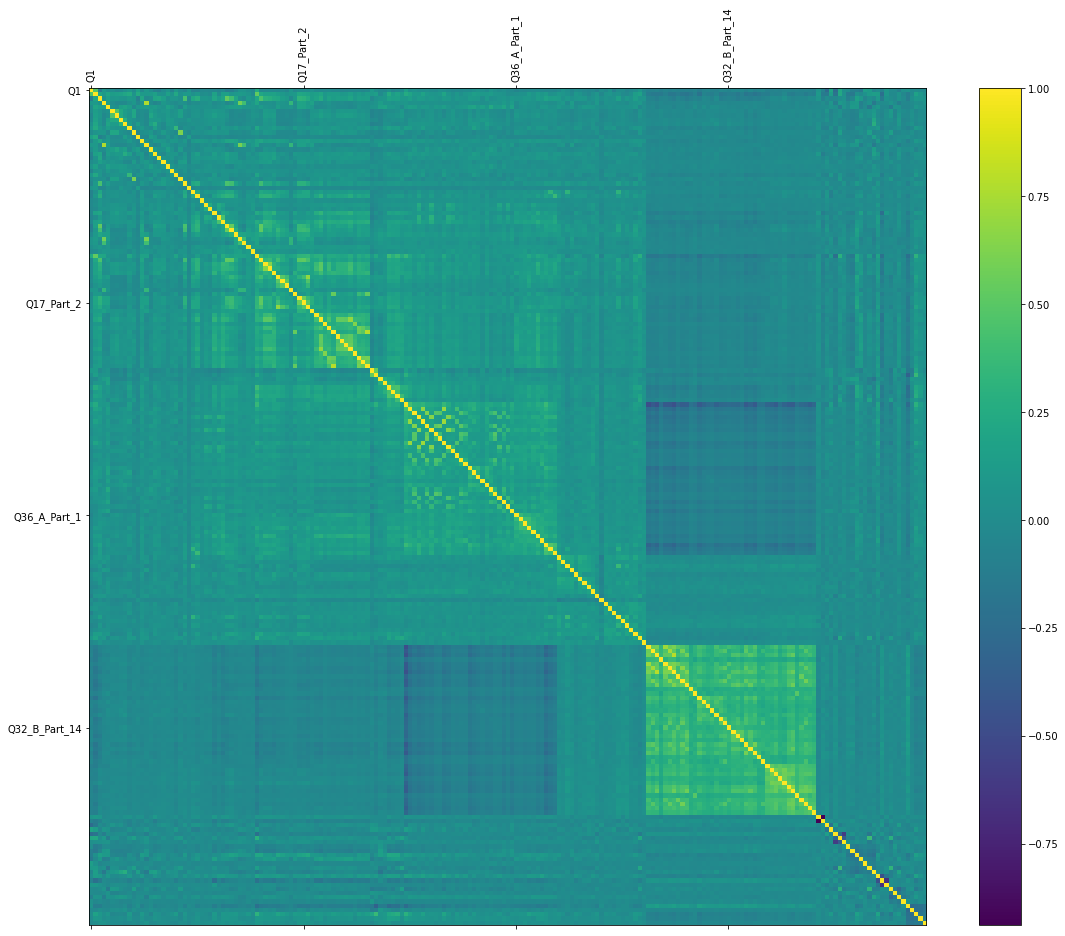

In [58]:
f = plt.figure(figsize=(19, 15))
plt.matshow(X_train.corr(), fignum=f.number)
plt.xticks(range(0,X_train.shape[1],50), X_train.columns[range(0,X_train.shape[1],50)], rotation=90)
plt.yticks(range(0,X_train.shape[1],50), X_train.columns[range(0,X_train.shape[1],50)])
cb = plt.colorbar()
cb.ax.tick_params()
plt.show()

Notice there are some blocks having some highly correlated features.

### Correlation between features and target (Q25_Encoded)

Then, I looked at the correlation between the features with the target, to understand which features are the most important and have the greatest impact on predicting the target.

In [59]:
features_and_target=pd.concat([X_train,y_train], axis=1)
corr_f_t=features_and_target.corr()[['Q25_Encoded'][:]]
corr_f_t=corr_f_t.sort_values(by=['Q25_Encoded'], ascending=False)
corr_f_t

,Q25_Encoded
Q25_Encoded,1.000000
Q3_United States of America,0.479142
Q6,0.396115
Q1,0.376212
Q26,0.371317
...,...
Q32_B_Part_1,-0.152517
Q4_Bachelor’s degree,-0.154453
Q31_B_Part_3,-0.154741
Q20_Academics/Education,-0.164159


In [60]:
corr_f_t.head(6)

,Q25_Encoded
Q25_Encoded,1.000000
Q3_United States of America,0.479142
Q6,0.396115
Q1,0.376212
Q26,0.371317
Q15,0.358383


In [61]:
print(df2.loc[0,'Q6'])
print(df2.loc[0,'Q1'])
print(df2.loc[0,'Q26'])
print(df2.loc[0,'Q15'])

For how many years have you been writing code and/or programming?
What is your age (# years)?
Approximately how much money have you (or your team) spent on machine learning and/or cloud computing services at home (or at work) in the past 5 years (approximate $USD)?
For how many years have you used machine learning methods?


As shown above, the features that have the biggest correlation with the target are the years of coding and programming experience, the age of the participant, the money they have spent on ML services, and the years they used ML methods. Notice that all of these have **positive** correlation, meaning the higher the value, the more likely the target (salary bucket) will be higher.

In [63]:
corr_f_t.index[range(0,corr_f_t.shape[0],10)]

Index(['Q25_Encoded', 'Q24_Part_3', 'Q27_A_Part_2', 'Q30_A_Part_1',
       'Q23_We recently started using ML methods (i.e., models in production for less than 2 years)',
       'Q19_Part_1', 'Q14_Part_3', 'Q36_A_Part_6', 'Q13', 'Q19_Part_2',
       'Q7_Part_1', 'Q9_Part_11', 'Q40_Part_8', 'Q7_Part_6', 'Q42_Part_4',
       'Q36_B_Part_5', 'Q32_B_Part_3', 'Q36_B_Part_3', 'Q37_B_Part_6',
       'Q29_B_Part_3'],
      dtype='object')

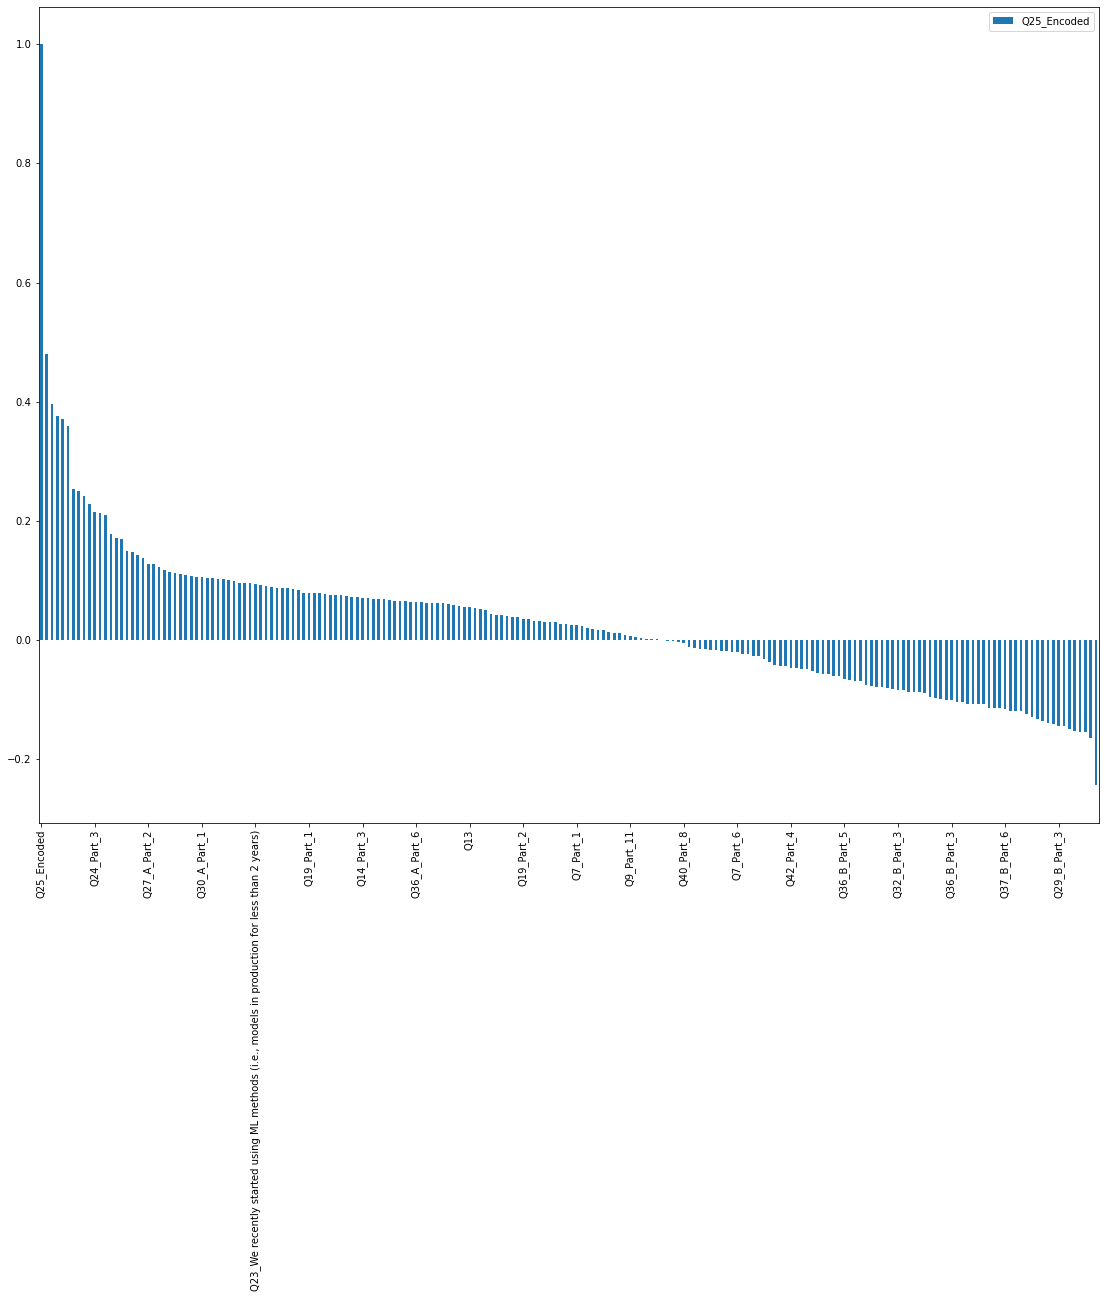

In [64]:
ax=corr_f_t.plot(kind='bar',figsize=(19, 15))
ax.set_xticks(ticks=range(0,corr_f_t.shape[0],10))
plt.show()

This graph shows us the correlation between the different features with the target of Q25_Encoded. The longer the bar, the more (positively or negatively depends on the direction of the bar) the feature is correlated to the target.

### Feature Selection

Before doing our feature selection, we should scale our training data because I will be using Lasso, which puts a coefficient to each feature depending on the magnitude of the feature. If the data is not standardized, the difference in scaling will make some unimportant but label encoded features have higher coefficients than one hot encoded features with more importance.

In [65]:
scaler = StandardScaler()
filtered_X=scaler.fit_transform(X_train)
filtered_X_df=pd.DataFrame(filtered_X,columns=X_train.columns)

filtered_y_df=pd.DataFrame(y_train,columns=y_train.columns)

In [66]:
filtered_X_df

,Q1,Q6,Q7_Part_1,Q7_Part_2,Q7_Part_3,Q7_Part_4,Q7_Part_5,Q7_Part_6,Q7_Part_7,Q7_Part_10,...,Q11_A personal computer / desktop,Q20_Academics/Education,Q20_Accounting/Finance,Q20_Computers/Technology,Q20_Manufacturing/Fabrication,Q23_No (we do not use ML methods),Q23_We are exploring ML methods (and may one day put a model into production),"Q23_We have well established ML methods (i.e., models in production for more than 2 years)","Q23_We recently started using ML methods (i.e., models in production for less than 2 years)",Q23_We use ML methods for generating insights (but do not put working models into production)
0,0.231167,0.598632,0.478501,-0.533423,1.081162,-0.386650,-0.432373,-0.435371,-0.443226,-0.350654,...,1.998304,-0.490708,-0.311874,-0.575596,-0.242573,1.958070,-0.525916,-0.438362,-0.413247,-0.343991
1,-1.079204,-1.135053,0.478501,1.874686,1.081162,-0.386650,-0.432373,-0.435371,-0.443226,-0.350654,...,-0.500424,2.037872,-0.311874,-0.575596,-0.242573,-0.510707,-0.525916,-0.438362,-0.413247,-0.343991
2,-0.642413,-1.135053,0.478501,-0.533423,-0.924931,2.586317,2.312820,-0.435371,-0.443226,-0.350654,...,-0.500424,2.037872,-0.311874,-0.575596,-0.242573,-0.510707,1.901444,-0.438362,-0.413247,-0.343991
3,-0.642413,-1.135053,0.478501,-0.533423,-0.924931,-0.386650,-0.432373,2.296892,-0.443226,-0.350654,...,-0.500424,-0.490708,3.206428,-0.575596,-0.242573,-0.510707,-0.525916,-0.438362,-0.413247,2.907054
4,1.104748,1.754422,-2.089861,-0.533423,1.081162,-0.386650,-0.432373,2.296892,2.256185,-0.350654,...,1.998304,-0.490708,-0.311874,-0.575596,-0.242573,1.958070,-0.525916,-0.438362,-0.413247,-0.343991
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10306,0.231167,1.176527,0.478501,-0.533423,-0.924931,-0.386650,-0.432373,2.296892,-0.443226,-0.350654,...,-0.500424,-0.490708,-0.311874,1.737330,-0.242573,-0.510707,-0.525916,-0.438362,2.419859,-0.343991
10307,-0.205623,0.020737,-2.089861,1.874686,-0.924931,-0.386650,-0.432373,-0.435371,-0.443226,-0.350654,...,-0.500424,2.037872,-0.311874,-0.575596,-0.242573,-0.510707,1.901444,-0.438362,-0.413247,-0.343991
10308,-0.642413,0.598632,0.478501,-0.533423,1.081162,-0.386650,-0.432373,-0.435371,-0.443226,-0.350654,...,-0.500424,-0.490708,-0.311874,-0.575596,-0.242573,-0.510707,-0.525916,2.281221,-0.413247,-0.343991
10309,1.541538,1.754422,0.478501,-0.533423,1.081162,-0.386650,-0.432373,-0.435371,2.256185,-0.350654,...,-0.500424,2.037872,-0.311874,-0.575596,-0.242573,-0.510707,-0.525916,-0.438362,-0.413247,-0.343991


In [67]:
filtered_y_df

,Q25_Encoded
8450,1.0
10559,0.0
9052,0.0
13150,0.0
3471,5.0
...,...
5192,0.0
13419,4.0
5391,2.0
861,0.0


As seen in this website: https://towardsdatascience.com/feature-selection-with-pandas-e3690ad8504b, using sklearn's modules LassoCV, which sets weights of the less important features to zero is a really powerful tool to reduce the features used to predict the target.

In [68]:
reg = LassoCV()
reg.fit(filtered_X_df, filtered_y_df)
print("Best alpha using built-in LassoCV: %f" % reg.alpha_)
print("Best score using built-in LassoCV: %f" %reg.score(filtered_X_df, filtered_y_df))
coef = pd.Series(reg.coef_, index = filtered_X_df.columns)

Best alpha using built-in LassoCV: 0.017758
Best score using built-in LassoCV: 0.505078


In [69]:
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Lasso picked 127 variables and eliminated the other 70 variables


Text(0.5, 1.0, 'Feature importance using Lasso Model')

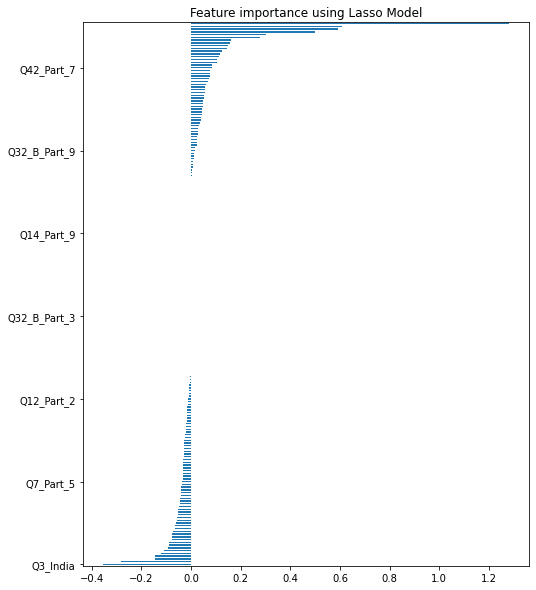

In [70]:
imp_coef = coef.sort_values()
plt.rcParams['figure.figsize'] = (8.0, 10.0)
ax=imp_coef.plot(kind = "barh")
ax.set_yticks(range(0,coef.shape[0],30))
plt.title("Feature importance using Lasso Model")

In [71]:
filtered_X_df=filtered_X_df.loc[:,coef!=0]
filtered_X_df

,Q1,Q6,Q7_Part_3,Q7_Part_4,Q7_Part_5,Q7_Part_7,Q7_Part_10,Q7_Part_11,Q7_OTHER,Q9_Part_2,...,"Q11_A cloud computing platform (AWS, Azure, GCP, hosted notebooks, etc)",Q11_A laptop,Q20_Academics/Education,Q20_Accounting/Finance,Q20_Computers/Technology,Q20_Manufacturing/Fabrication,Q23_No (we do not use ML methods),Q23_We are exploring ML methods (and may one day put a model into production),"Q23_We have well established ML methods (i.e., models in production for more than 2 years)","Q23_We recently started using ML methods (i.e., models in production for less than 2 years)"
0,0.231167,0.598632,1.081162,-0.386650,-0.432373,-0.443226,-0.350654,-0.333136,2.632782,-0.498909,...,-0.351351,-1.320234,-0.490708,-0.311874,-0.575596,-0.242573,1.958070,-0.525916,-0.438362,-0.413247
1,-1.079204,-1.135053,1.081162,-0.386650,-0.432373,-0.443226,-0.350654,-0.333136,-0.379826,2.004375,...,-0.351351,0.757442,2.037872,-0.311874,-0.575596,-0.242573,-0.510707,-0.525916,-0.438362,-0.413247
2,-0.642413,-1.135053,-0.924931,2.586317,2.312820,-0.443226,-0.350654,-0.333136,-0.379826,-0.498909,...,-0.351351,-1.320234,2.037872,-0.311874,-0.575596,-0.242573,-0.510707,1.901444,-0.438362,-0.413247
3,-0.642413,-1.135053,-0.924931,-0.386650,-0.432373,-0.443226,-0.350654,3.001779,-0.379826,-0.498909,...,-0.351351,0.757442,-0.490708,3.206428,-0.575596,-0.242573,-0.510707,-0.525916,-0.438362,-0.413247
4,1.104748,1.754422,1.081162,-0.386650,-0.432373,2.256185,-0.350654,-0.333136,-0.379826,-0.498909,...,-0.351351,-1.320234,-0.490708,-0.311874,-0.575596,-0.242573,1.958070,-0.525916,-0.438362,-0.413247
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10306,0.231167,1.176527,-0.924931,-0.386650,-0.432373,-0.443226,-0.350654,-0.333136,-0.379826,-0.498909,...,-0.351351,0.757442,-0.490708,-0.311874,1.737330,-0.242573,-0.510707,-0.525916,-0.438362,2.419859
10307,-0.205623,0.020737,-0.924931,-0.386650,-0.432373,-0.443226,-0.350654,-0.333136,-0.379826,2.004375,...,-0.351351,0.757442,2.037872,-0.311874,-0.575596,-0.242573,-0.510707,1.901444,-0.438362,-0.413247
10308,-0.642413,0.598632,1.081162,-0.386650,-0.432373,-0.443226,-0.350654,-0.333136,-0.379826,-0.498909,...,2.846158,-1.320234,-0.490708,-0.311874,-0.575596,-0.242573,-0.510707,-0.525916,2.281221,-0.413247
10309,1.541538,1.754422,1.081162,-0.386650,-0.432373,2.256185,-0.350654,-0.333136,-0.379826,-0.498909,...,-0.351351,0.757442,2.037872,-0.311874,-0.575596,-0.242573,-0.510707,-0.525916,-0.438362,-0.413247


Since we still have 127 features, I will apply RFE to further remove the less important features. The reason we are able to use consecutively Lasso then RFE is because RFE recursively eliminates the features that do not add much value to the target prediction using an estimator of our choice. 

I used Random Forest Classifier (RFC) since as stated in the following source: https://stats.stackexchange.com/questions/430304/random-forest-ordinal-data, RFC is helpful in cases where the target is ordinal. This extra step will allow us to check if there are additional non important features that are causing noise (one of Lasso's disadvantages is that sometimes it might leave noisey features thinking they are important).

However, one assumption I made was that the method will be selecting half (arbitrary number) the number of features. This could have been avoided by iterating over all possible numbers of features, however, with the constraints of computational power and time, I decided to select only one value. This should not have a great impact on the predictions since we still have 63 relevant features.

In [72]:
model=RandomForestClassifier(max_depth=3, random_state=42) # Max depth is set to 3 for computational power restrictions
rfe = RFE(model)
X_rfe = rfe.fit_transform(filtered_X_df,filtered_y_df)
model.fit(X_rfe,filtered_y_df)
print(rfe.support_)

[ True  True  True  True  True  True  True  True  True False  True False
  True  True  True False  True  True False  True False  True False  True
 False  True False False False  True  True False  True  True False False
  True False False False False False  True  True False  True  True False
  True  True  True False False False  True False False False False False
 False False False False False False False False False False False  True
 False False  True False False False  True False  True  True  True  True
 False  True False False False  True  True False  True  True False False
 False False False False False False False  True False  True  True  True
  True  True  True  True  True  True  True False False  True  True  True
  True False  True  True  True  True False]


In [73]:
print(rfe.ranking_)

[ 1  1  1  1  1  1  1  1  1  3  1  5  1  1  1 34  1  1 14  1 24  1 39  1
 38  1 10 21 45  1  1 42  1  1 29  4  1  9 40 35 31 51  1  1  7  1  1 49
  1  1  1 50 48 57  1 18 22 52 54 56 60 59 64 65 63 53 26 46 19 37 55  1
 15  8  1 32 28 30  1 47  1  1  1  1  6  1 23 61 11  1  1 44  1  1 62 16
 25 20  2 17 13 33 27  1 12  1  1  1  1  1  1  1  1  1  1 41 36  1  1  1
  1 43  1  1  1  1 58]


In the following graph, the smaller the value the better. Therefore all the features with high values are NOT important and will be dropped.

Text(0.5, 1.0, 'Feature Ranking from RFE')

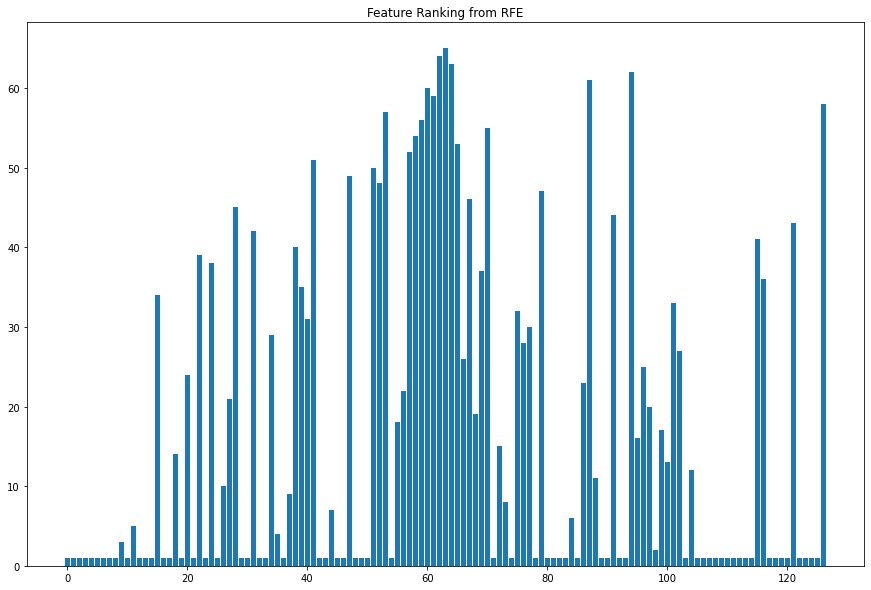

In [74]:
plt.rcParams['figure.figsize'] = (15, 10.0)
plt.bar([x for x in range(len(rfe.ranking_))], rfe.ranking_)
plt.title("Feature Ranking from RFE")

The features to be selected are the ones with rank 1 (or with support = True).

In [75]:
filtered_X_df=filtered_X_df.loc[:,rfe.support_]
filtered_X_df

,Q1,Q6,Q7_Part_3,Q7_Part_4,Q7_Part_5,Q7_Part_7,Q7_Part_10,Q7_Part_11,Q7_OTHER,Q9_Part_3,...,Q5_Machine Learning Engineer,Q5_Program/Project Manager,"Q11_A cloud computing platform (AWS, Azure, GCP, hosted notebooks, etc)",Q11_A laptop,Q20_Academics/Education,Q20_Accounting/Finance,Q20_Manufacturing/Fabrication,Q23_No (we do not use ML methods),Q23_We are exploring ML methods (and may one day put a model into production),"Q23_We have well established ML methods (i.e., models in production for more than 2 years)"
0,0.231167,0.598632,1.081162,-0.386650,-0.432373,-0.443226,-0.350654,-0.333136,2.632782,2.357787,...,-0.30981,-0.229287,-0.351351,-1.320234,-0.490708,-0.311874,-0.242573,1.958070,-0.525916,-0.438362
1,-1.079204,-1.135053,1.081162,-0.386650,-0.432373,-0.443226,-0.350654,-0.333136,-0.379826,-0.424126,...,-0.30981,-0.229287,-0.351351,0.757442,2.037872,-0.311874,-0.242573,-0.510707,-0.525916,-0.438362
2,-0.642413,-1.135053,-0.924931,2.586317,2.312820,-0.443226,-0.350654,-0.333136,-0.379826,-0.424126,...,-0.30981,-0.229287,-0.351351,-1.320234,2.037872,-0.311874,-0.242573,-0.510707,1.901444,-0.438362
3,-0.642413,-1.135053,-0.924931,-0.386650,-0.432373,-0.443226,-0.350654,3.001779,-0.379826,-0.424126,...,-0.30981,-0.229287,-0.351351,0.757442,-0.490708,3.206428,-0.242573,-0.510707,-0.525916,-0.438362
4,1.104748,1.754422,1.081162,-0.386650,-0.432373,2.256185,-0.350654,-0.333136,-0.379826,-0.424126,...,-0.30981,-0.229287,-0.351351,-1.320234,-0.490708,-0.311874,-0.242573,1.958070,-0.525916,-0.438362
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10306,0.231167,1.176527,-0.924931,-0.386650,-0.432373,-0.443226,-0.350654,-0.333136,-0.379826,-0.424126,...,-0.30981,-0.229287,-0.351351,0.757442,-0.490708,-0.311874,-0.242573,-0.510707,-0.525916,-0.438362
10307,-0.205623,0.020737,-0.924931,-0.386650,-0.432373,-0.443226,-0.350654,-0.333136,-0.379826,-0.424126,...,-0.30981,-0.229287,-0.351351,0.757442,2.037872,-0.311874,-0.242573,-0.510707,1.901444,-0.438362
10308,-0.642413,0.598632,1.081162,-0.386650,-0.432373,-0.443226,-0.350654,-0.333136,-0.379826,-0.424126,...,-0.30981,-0.229287,2.846158,-1.320234,-0.490708,-0.311874,-0.242573,-0.510707,-0.525916,2.281221
10309,1.541538,1.754422,1.081162,-0.386650,-0.432373,2.256185,-0.350654,-0.333136,-0.379826,-0.424126,...,-0.30981,-0.229287,-0.351351,0.757442,2.037872,-0.311874,-0.242573,-0.510707,-0.525916,-0.438362


The reason why I did not choose PCA is that as seen in https://towardsdatascience.com/pca-is-not-feature-selection-3344fb764ae6, PCA should not be used when the features are non-continuous, which is what we have. For this reason, I decided to use the consecutive feature selection models.

Text(0.5, 1.0, 'Feature importance using RFE')

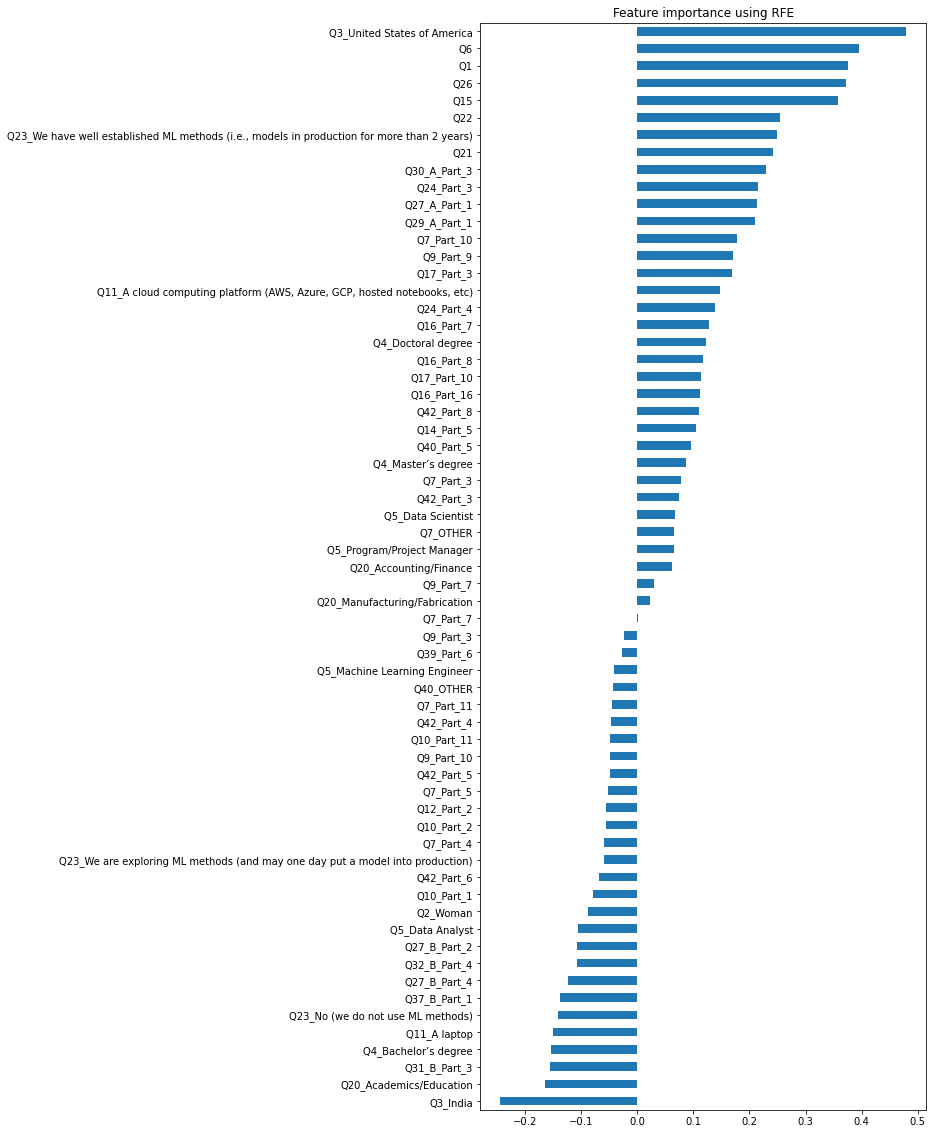

In [76]:
updated_feature_importance=corr_f_t.loc[np.array(filtered_X_df.columns)]
sorted_updated_feature_importance = updated_feature_importance['Q25_Encoded'].sort_values()
plt.rcParams['figure.figsize'] = (8.0, 20.0)
ax=sorted_updated_feature_importance.plot(kind = "barh")
ax.set_yticks(range(0,updated_feature_importance.shape[0]))
plt.title("Feature importance using RFE")

## Model Implementation

I already divided the training and testing sets, but I need to perform 10-fold cross validation to train the model and predict on validations sets.

One method that is commonly used is LogisticRegression with the option of multi-class option being multinomial, which is not very accurate since it ignores the ordered relationship of the target classes. There is another module called mord, which does the ordinal logistic regression. Therefore, I will be trying both: 1) writing my own ordinal logistic regression function, and 2) running mord.

In [77]:
filtered_y_df['Q25_Encoded'].value_counts()

0.0     4727
1.0     1017
2.0      707
3.0      493
4.0      478
10.0     474
5.0      455
6.0      376
7.0      310
11.0     257
8.0      254
12.0     249
9.0      238
13.0     156
14.0     120
Name: Q25_Encoded, dtype: int64

I will be looking at the F1 score and root mean squared error to evaluate the ordinal classification models, as research says these two are highly important (https://link.springer.com/chapter/10.1007/978-3-642-01818-3_25). F1 score is more helpful than the average as a performance metric in our case because our data is imbalanced. F1 score takes it into consideration, specifically after setting the average being calculated as 'weighted', meaning it considers the difference in counts of every label.

I tried balancing the dataset using SMOTE, however, the results were worse than the ones I got when the data was imbalanced. For that reason, I did not balance the dataset, but took into account in the F1 score, the average to be weighted with respect to the different counts of the labels. A reason for the balanced dataset to give us worse results could be that the number of features is too little, and we would be fitting a large dataset with just a few features. Additionally, the resampling could be generated in an inappropriate way using SMOTE, other methods could be used, however, for the scope of this code, I decided to keep the data imbalanced.

### Manual Ordinal Logistic Regression

In [78]:
def ordinal_logistic_regression (model):
    
    X = filtered_X_df
    Y = filtered_y_df
    
    kf = KFold(n_splits=10) 
    val_accuracy = []
    train_accuracy=[]
    mse=[]
    fold = 0
    
    unique_classes=np.sort(Y['Q25_Encoded'].unique())
    bn_c=np.zeros(((len(Y['Q25_Encoded'].unique())-1,(len(Y['Q25_Encoded'].unique())))))

    for i in range(len(Y['Q25_Encoded'].unique())-1):
        bn_c[i,:]=np.where(unique_classes<=i,0,1)

    bn_c
    
    for train_index, test_index in kf.split(X):
        fold += 1
        X_train, X_val = X.values[train_index], X.values[test_index]
        Y_train, Y_val = Y.values[train_index].astype(int), Y.values[test_index].astype(int)
        
        
        #############################################################

        # Creating the 14 models of Logistic Regression and saving them to file
        
        Y_train=pd.DataFrame(Y_train, columns=['Q25_Encoded'])
            
        
        for i in range(len(Y_train['Q25_Encoded'].unique())-1):
            changed_y=Y_train.copy()
            changed_y=changed_y.replace(unique_classes,bn_c[i])
            fitted_model=model.fit(X_train,changed_y)
            pkl_filename = "model {0}.pkl".format(i)
            with open(pkl_filename, 'wb') as file:
                pickle.dump(model, file)
            
            
            
        #############################################################
        
        # Predicting validation and training classes
        
        val_p=np.zeros((len(X_val),len(unique_classes)))
        train_p=np.zeros((len(X_train),len(unique_classes)))

        for j in range(val_p.shape[1]):
            if j==0:
                pickle_model = pickle.load(open("model {0}.pkl".format(j), 'rb'))
                val_p[:,j]=pickle_model.predict_proba(X_val)[:,0]
                train_p[:,j]=pickle_model.predict_proba(X_train)[:,0]
            elif j==(val_p.shape[1]-1):
                pickle_model = pickle.load(open("model {0}.pkl".format(len(unique_classes)-2), 'rb'))
                val_p[:,j]=pickle_model.predict_proba(X_val)[:,1]
                train_p[:,j]=pickle_model.predict_proba(X_train)[:,1]
            else:
                pickle_model = pickle.load(open("model {0}.pkl".format(j), 'rb'))
                previous_pickle_model= pickle.load(open("model {0}.pkl".format(j-1), 'rb'))
                val_p[:,j]=np.maximum((pickle_model.predict_proba(X_val)[:,0]-previous_pickle_model.predict_proba(X_val)[:,0]),0) # Note that because of the subtraction, some discrepancies can occur and have negative probabilities. To prevent this we set the negative values to 0
                train_p[:,j]=np.maximum((pickle_model.predict_proba(X_train)[:,0]-previous_pickle_model.predict_proba(X_train)[:,0]),0)

        
        val_predictions=np.argmax(val_p,axis=1)
        train_predictions=np.argmax(train_p,axis=1)
        val_accuracy.append(f1_score(Y_val, val_predictions, average='weighted'))
        train_accuracy.append(f1_score(Y_train, train_predictions, average='weighted'))
        mse.append(mean_squared_error(Y_val, val_predictions, squared=False))
        print("Fold:", fold, " F1 score:", val_accuracy[-1])
        print("Fold:", fold, " MSE:", mse[-1])
        
        
    mean_accuracy = np.mean(val_accuracy)
    var_accuracy=np.var(val_accuracy)
    mean_mse=np.mean(mse)
    var_mse=np.var(mse)
    return val_p, val_accuracy, train_accuracy, mean_accuracy, var_accuracy, mean_mse, var_mse, mse

The following Logistic Regression model will be the baseline that we compare others to. I will use the same Logistic Regression estimator to fit the data (every time having different classes as 0 and others as 1). The reason why I am using the solver 'saga' is to keep the consistency with the next models, and saga allows us to have the 'l1' penalty.

In [79]:
model1=LogisticRegression(solver='saga', random_state=42) #random state to have the same results always
val_probabilities_manual, fold_val_accuracy_manual, fold_train_accuracy_manual, mean_accuracy_manual, var_accuracy_manual, mean_mse_manual, var_mse_manual,fold_mse_manual=ordinal_logistic_regression(model1)
print("Mean F1 score: {0}".format(mean_accuracy_manual)) 
print("Variance: {0}".format(var_accuracy_manual))
print("Mean RMSE: {0}".format(mean_mse_manual)) 
print("Variance: {0}".format(var_mse_manual))

Fold: 1  F1 score: 0.361947553076359
Fold: 1  MSE: 3.5804702822199856
Fold: 2  F1 score: 0.33755971553742803
Fold: 2  MSE: 3.891845288268491
Fold: 3  F1 score: 0.36786337128777247
Fold: 3  MSE: 3.4402196938846865
Fold: 4  F1 score: 0.38786741016630066
Fold: 4  MSE: 3.6569692178537374
Fold: 5  F1 score: 0.35051078220778314
Fold: 5  MSE: 3.8980708501841375
Fold: 6  F1 score: 0.37924173383355675
Fold: 6  MSE: 3.8051473637361033
Fold: 7  F1 score: 0.3548806857429538
Fold: 7  MSE: 3.51041128514632
Fold: 8  F1 score: 0.3499249209658195
Fold: 8  MSE: 3.6476744115939255
Fold: 9  F1 score: 0.3580611594201946
Fold: 9  MSE: 3.579497604941612
Fold: 10  F1 score: 0.35848854243654044
Fold: 10  MSE: 3.449229942595335
Mean F1 score: 0.36063458746747085
Variance: 0.00019358052525908623
Mean RMSE: 3.645953594042434
Variance: 0.025759561045235257


To plot the distribution of each class, I will create the salary buckets in an ordered manner.

First, I averaged our the probabilities of every class for all participants in the last fold and found the distribution of the probability of any random participant of belonging to each class.

Text(0.5, 1.0, 'Probability Distribution of Classes')

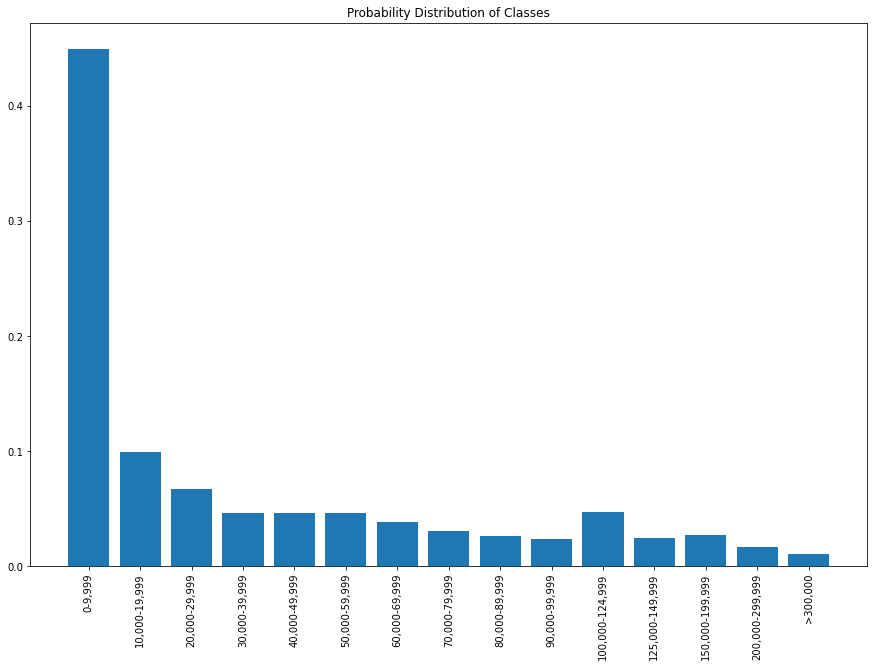

In [80]:
salary_buckets=['0-9,999', '10,000-19,999', '20,000-29,999','30,000-39,999', '40,000-49,999', '50,000-59,999', '60,000-69,999', '70,000-79,999', '80,000-89,999', '90,000-99,999', '100,000-124,999', '125,000-149,999', '150,000-199,999', '200,000-299,999', '>300,000']
plt.figure(figsize=(15, 10))
average_probs=np.mean(val_probabilities_manual, axis=0)
plt.bar(salary_buckets, height=average_probs)
plt.xticks(rotation=90)
plt.title("Probability Distribution of Classes")

Second, I looked into every class, and the distribution of probabilities of the participants belonging to each class.

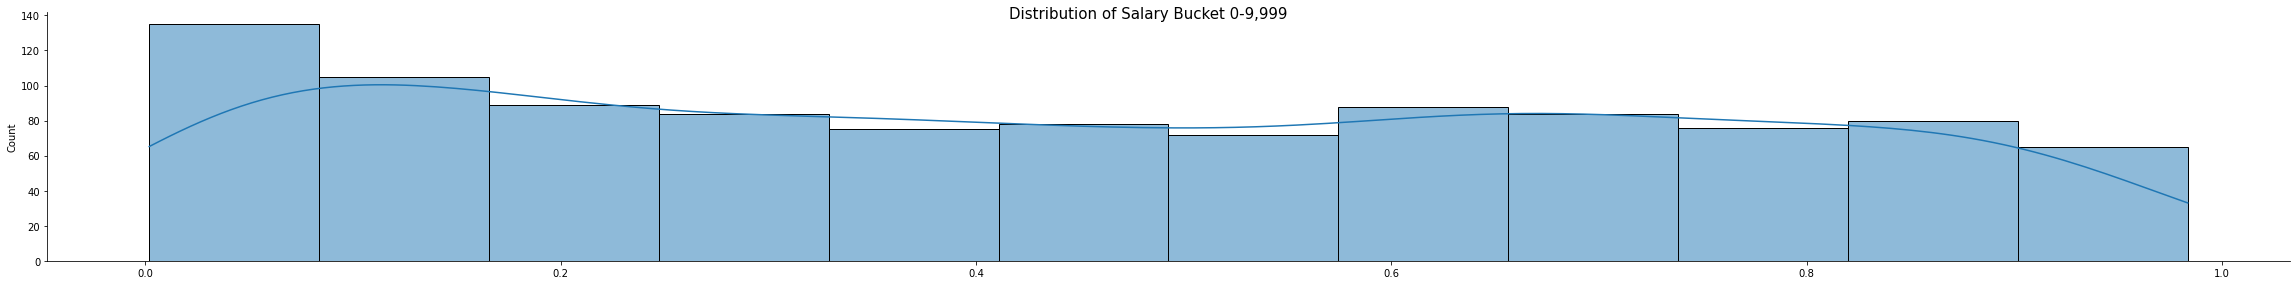

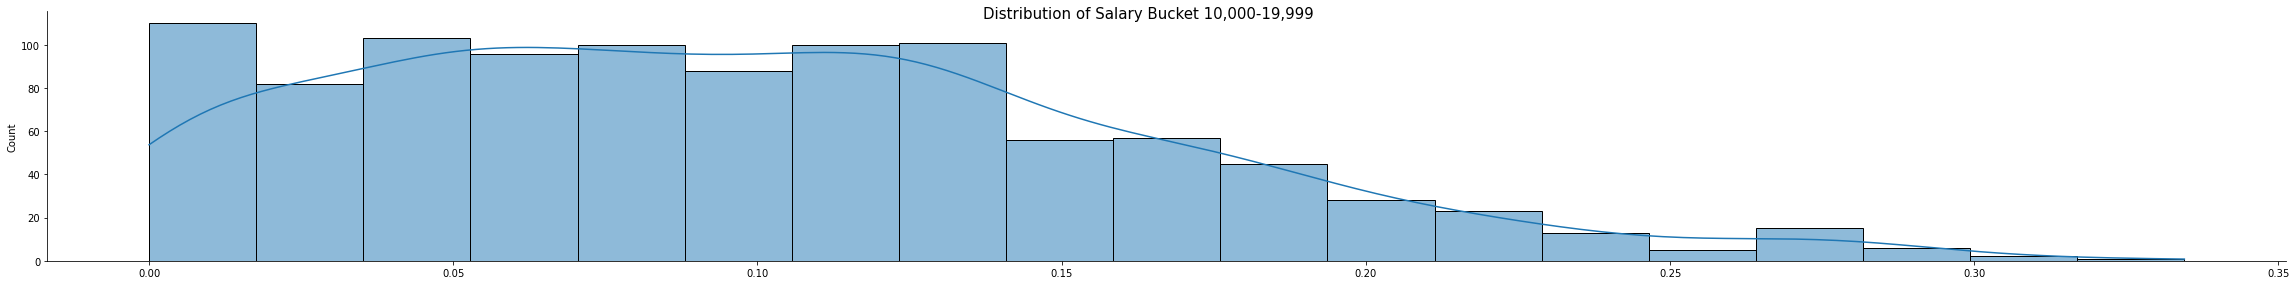

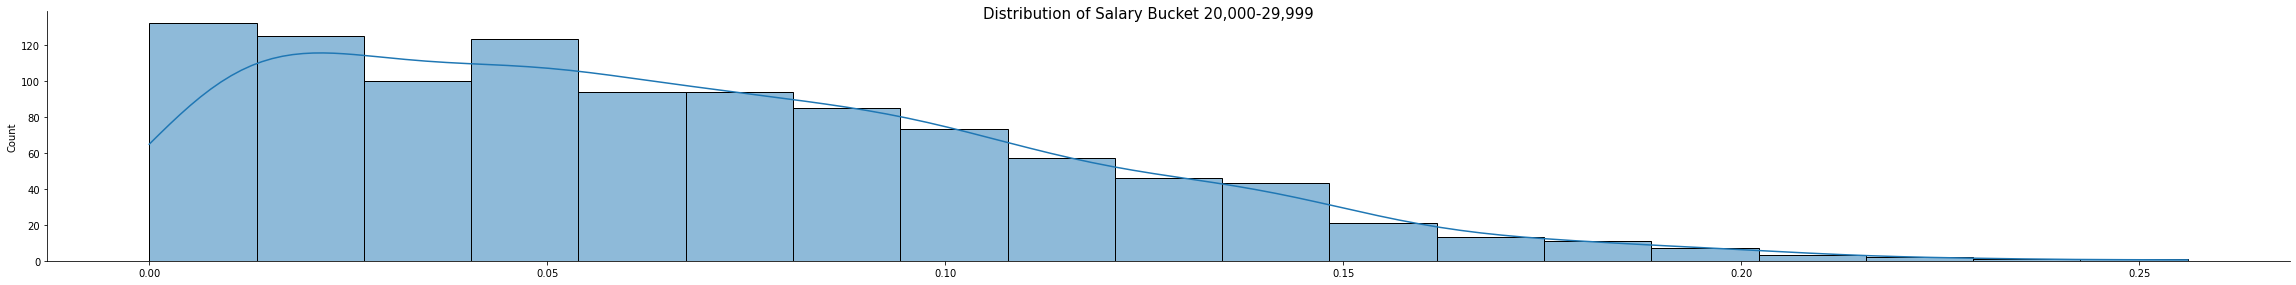

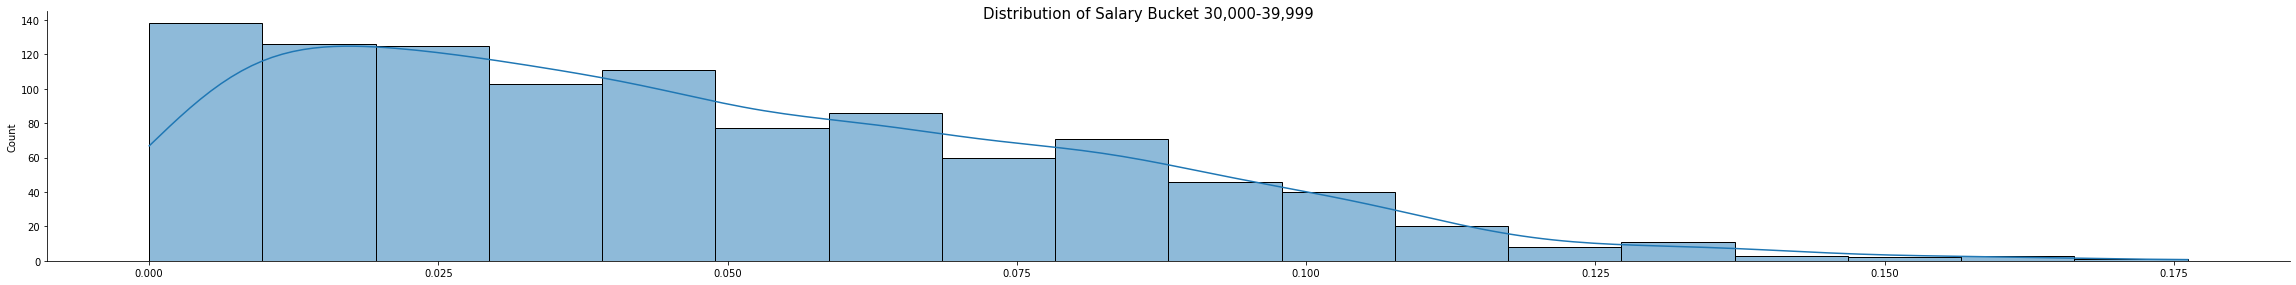

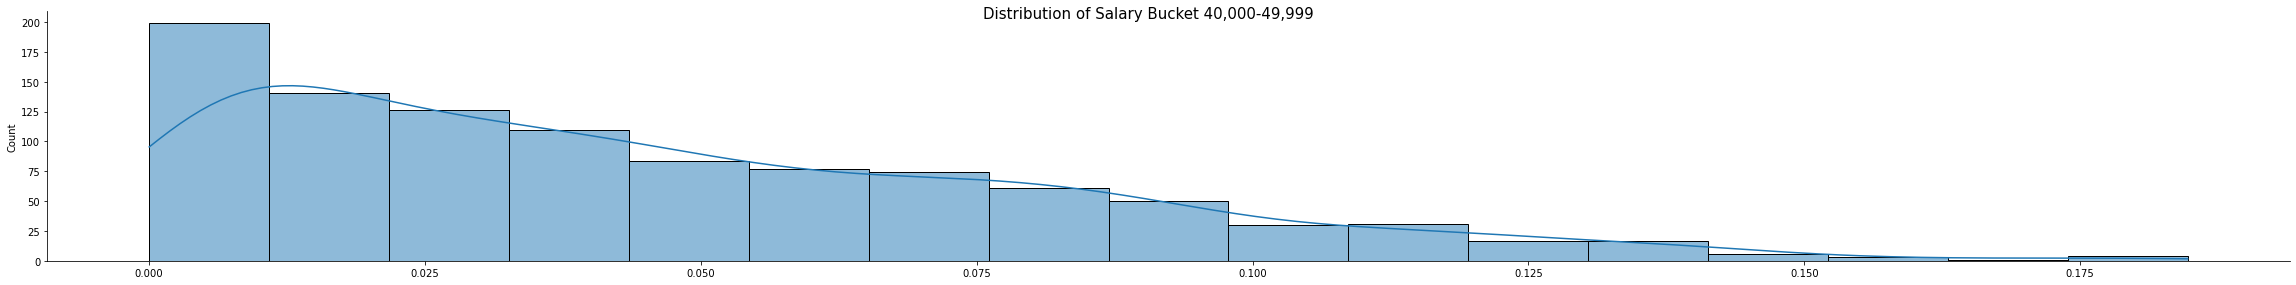

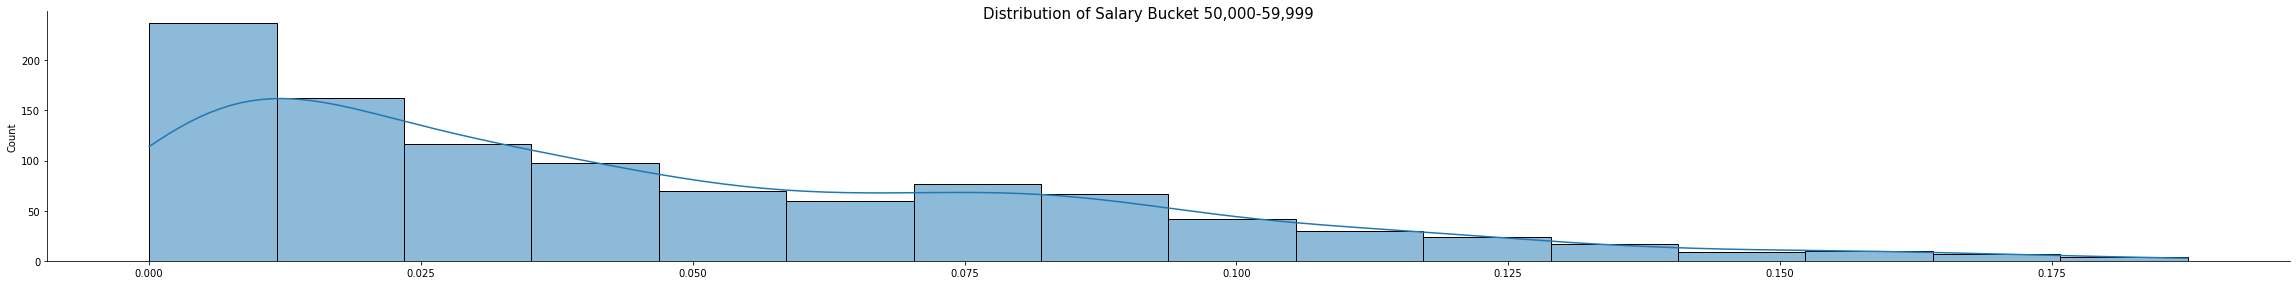

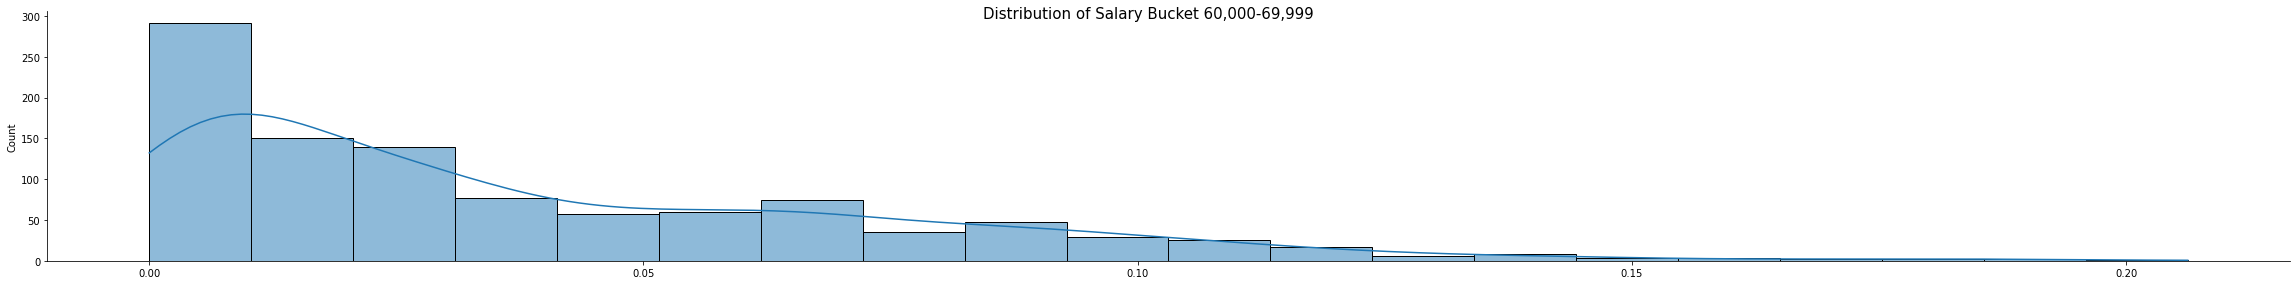

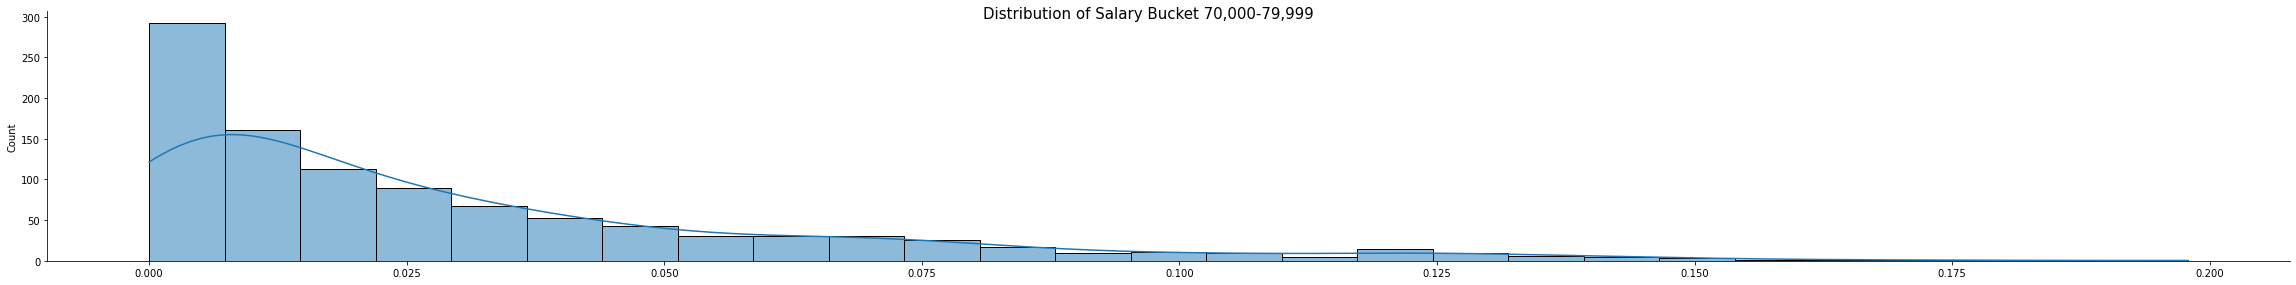

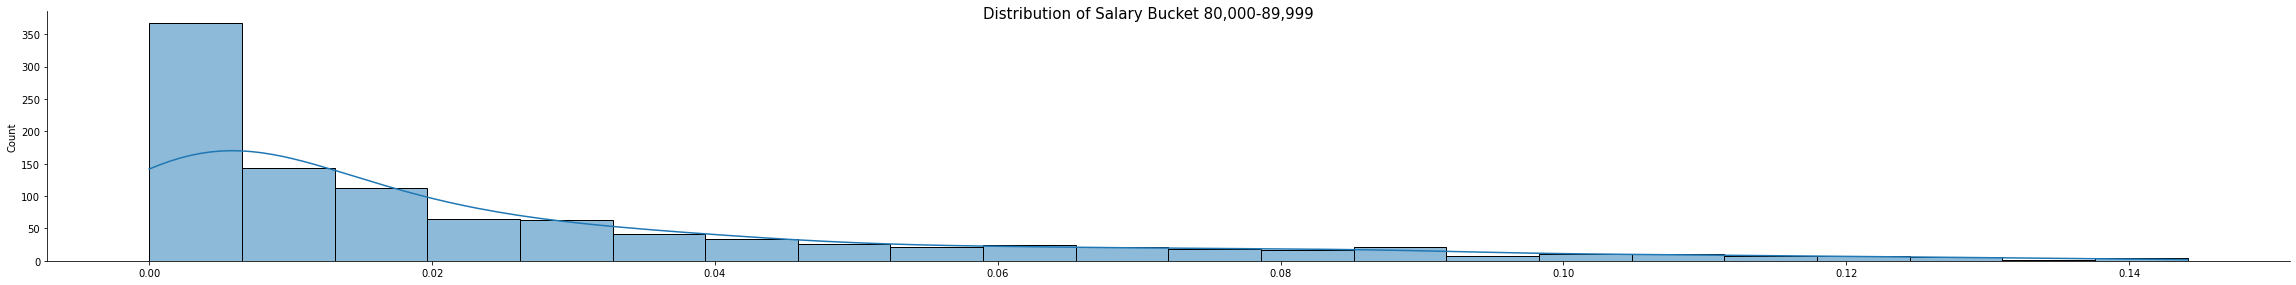

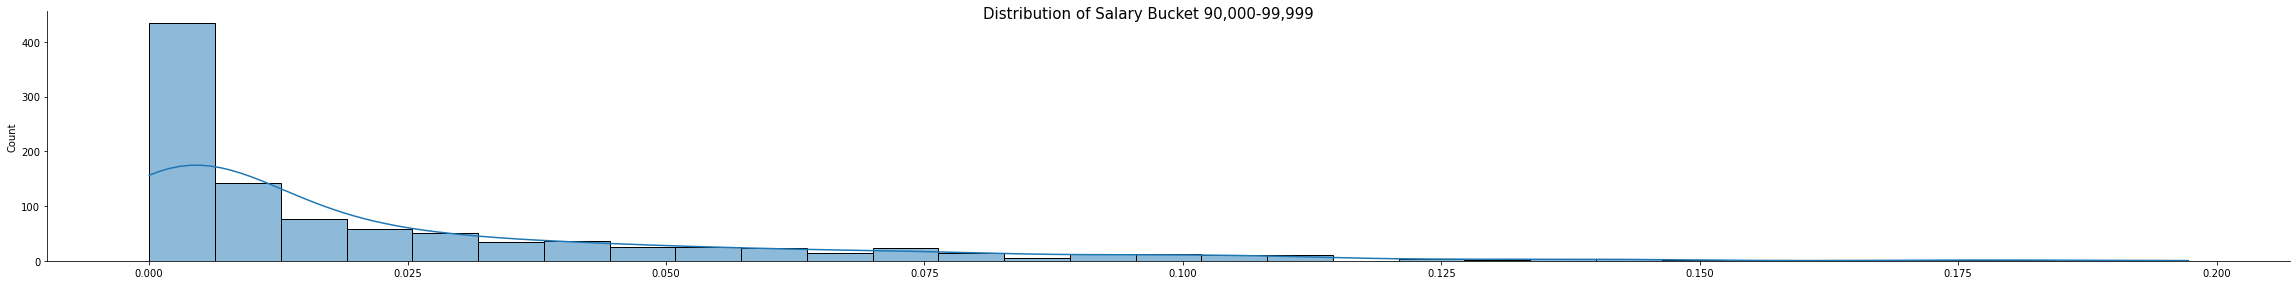

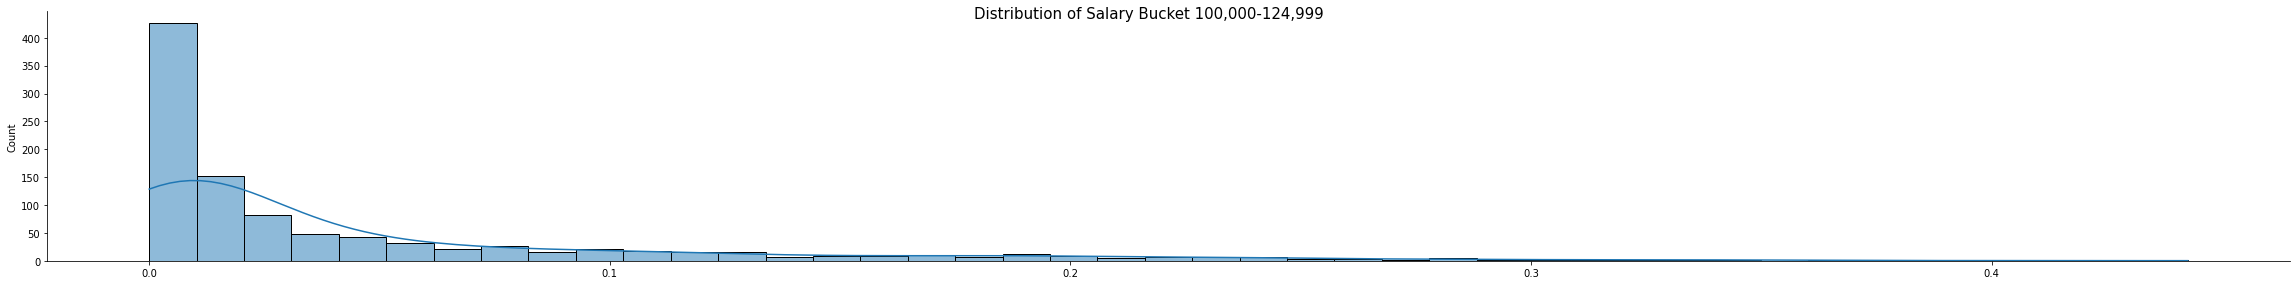

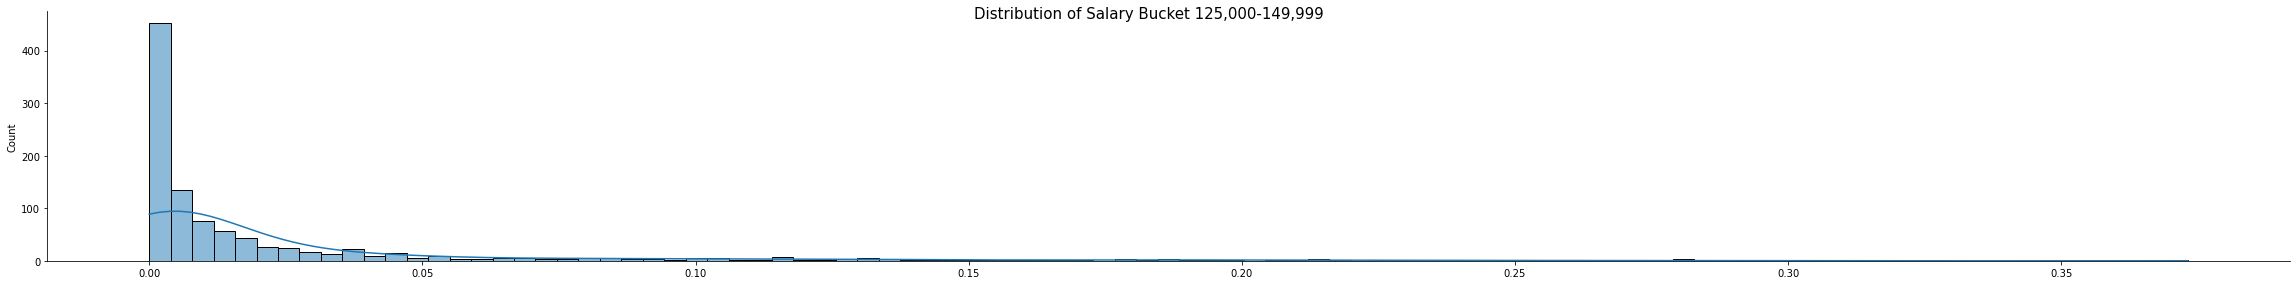

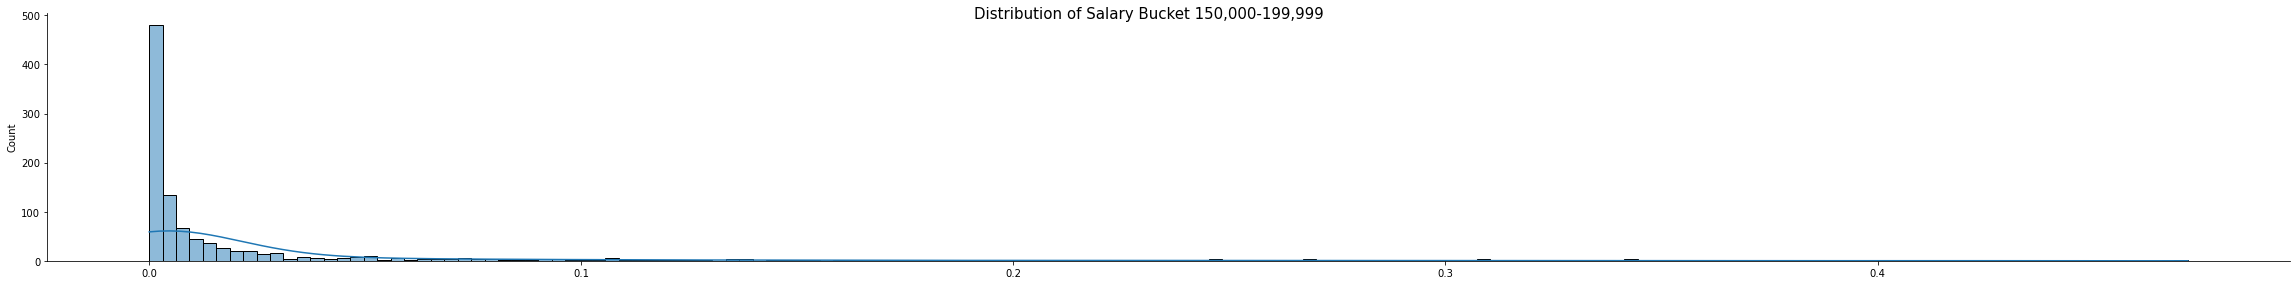

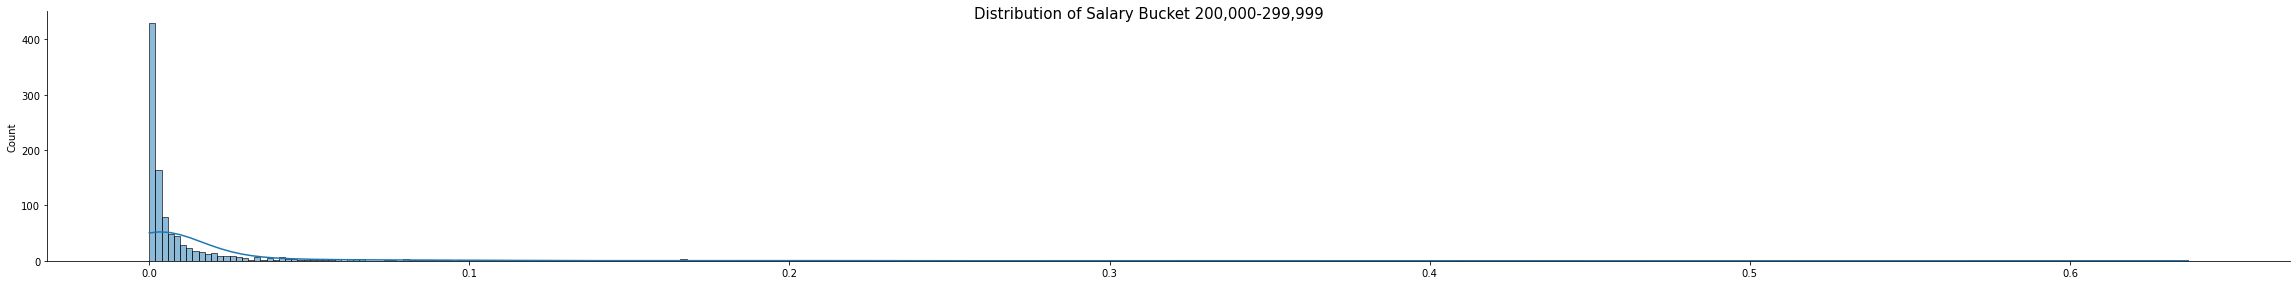

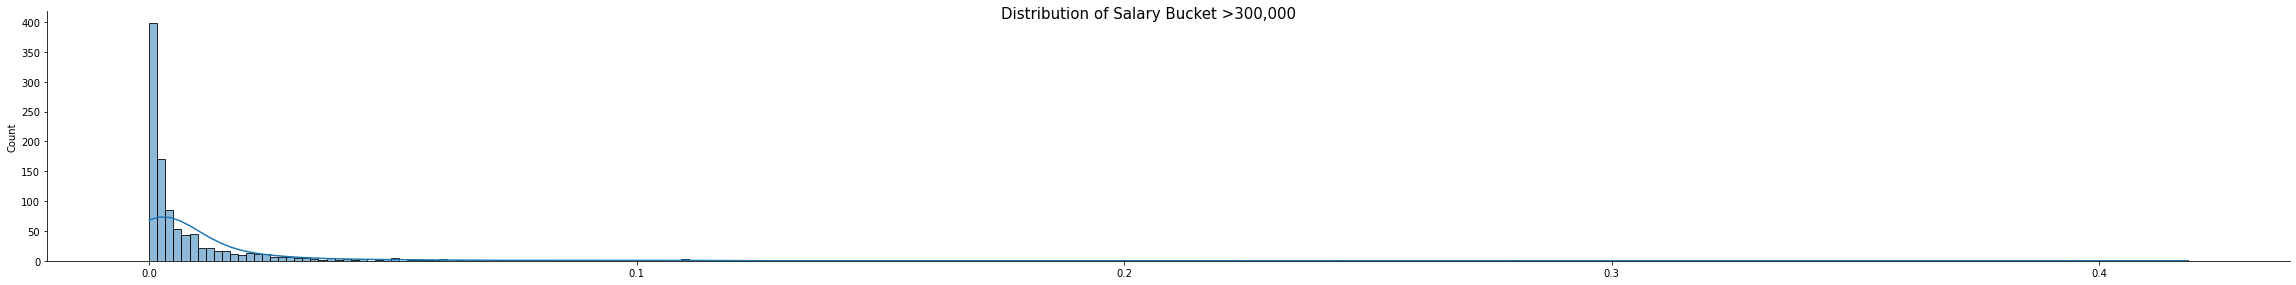

In [81]:
for i in range(len(salary_buckets)):
    ax=sns.displot(val_probabilities_manual[:,i], kde=True, height=4,aspect=8)
    ax.fig.suptitle("Distribution of Salary Bucket {0}".format(salary_buckets[i]), fontsize=15)

### Mord Module

Next I explored if the mord function gives us similar answers as the manual ordinal logistic regression.

In [82]:
def mord_kfold (model):
    
    X = filtered_X_df
    Y = filtered_y_df
    
    kf = KFold(n_splits=10)
    
    val_accuracy = []
    train_accuracy=[]
    mse=[]
    fold = 0
    
    for train_index, test_index in kf.split(X):
        fold += 1
        X_train, X_val = X.values[train_index], X.values[test_index]
        Y_train, Y_val = Y.values[train_index].astype(int), Y.values[test_index].astype(int)
        
        
        model.fit(X_train, Y_train)
        train_predictions= model.predict(X_train)
        val_predictions = model.predict(X_val)
        probability=model.predict_proba(X_val)  
        train_accuracy.append(f1_score(Y_train, train_predictions, average='weighted'))
        val_accuracy.append(f1_score(Y_val, val_predictions, average='weighted'))
        mse.append(mean_squared_error(Y_val, val_predictions, squared=False))
        print("Fold {0} accuracy: {1}".format(fold, val_accuracy[-1]))
        print("Fold {0} mse: {1}".format(fold, mse[-1]))
        
        
    mean_accuracy = np.mean(val_accuracy)
    var_accuracy=np.var(val_accuracy)
    mean_mse = np.mean(mse)
    var_mse=np.var(mse)
    return model, train_accuracy, val_accuracy, mean_accuracy, var_accuracy, mean_mse, var_mse, mse

Mord has two functions, LogisticAT and LogisticIT, one assuming intermediate threshold, and the other assuming all threshold variants (which are related to the loss function). So I checked both of them.

In [83]:
model2=mord.LogisticAT(alpha=1.)
model_auto, fold_train_accuracy_auto, fold_val_accuracy_auto, mean_accuracy_auto, var_accuracy_auto,mean_mse_auto,var_mse_auto,fold_mse_auto=mord_kfold(model2)
print("Mean F1 score: {0}".format(mean_accuracy_auto)) 
print("Variance: {0}".format(var_accuracy_auto))
print("Mean RMSE: {0}".format(mean_mse_auto)) 
print("Variance: {0}".format(var_mse_auto))

Fold 1 accuracy: 0.39744428652561314
Fold 1 mse: 2.967034643148511
Fold 2 accuracy: 0.4064223576559585
Fold 2 mse: 3.009361404363998
Fold 3 accuracy: 0.41403729573650216
Fold 3 mse: 2.8165714414465093
Fold 4 accuracy: 0.41352617336089786
Fold 4 mse: 2.9944986739750625
Fold 5 accuracy: 0.3834884437981345
Fold 5 mse: 3.087316438819393
Fold 6 accuracy: 0.4287625777964807
Fold 6 mse: 3.128976616303392
Fold 7 accuracy: 0.38042602276134185
Fold 7 mse: 2.8601411453779684
Fold 8 accuracy: 0.3962506662567662
Fold 8 mse: 3.018693777803789
Fold 9 accuracy: 0.3895168846817789
Fold 9 mse: 2.87097248788423
Fold 10 accuracy: 0.3956270763164116
Fold 10 mse: 2.8691137609087387
Mean F1 score: 0.40055017848898855
Variance: 0.00020508880493910745
Mean RMSE: 2.9622680390031593
Variance: 0.009856203357056243


In [84]:
model3=mord.LogisticIT(alpha=1.)
model_auto2, fold_train_accuracy_auto2, fold_val_accuracy_auto2, mean_accuracy_auto2, var_accuracy_auto2,mean_mse_auto2,var_mse_auto2, fold_mse_auto2=mord_kfold(model3)
print("Mean F1 score: {0}".format(mean_accuracy_auto2)) 
print("Variance: {0}".format(var_accuracy_auto2))
print("Mean RMSE: {0}".format(mean_mse_auto2)) 
print("Variance: {0}".format(var_mse_auto2))

Fold 1 accuracy: 0.34011835529070994
Fold 1 mse: 3.7371225924924953
Fold 2 accuracy: 0.3182388236781463
Fold 2 mse: 3.9783604770500656
Fold 3 accuracy: 0.3487128308899653
Fold 3 mse: 3.7173408098278062
Fold 4 accuracy: 0.35062906806178024
Fold 4 mse: 3.8940876371369972
Fold 5 accuracy: 0.31345658533268583
Fold 5 mse: 4.0684015740342385
Fold 6 accuracy: 0.35341930384808534
Fold 6 mse: 4.002181752230344
Fold 7 accuracy: 0.33125677719792757
Fold 7 mse: 3.7360798866586933
Fold 8 accuracy: 0.32632010978144876
Fold 8 mse: 3.870352881301677
Fold 9 accuracy: 0.3256181967133046
Fold 9 mse: 3.760791133724844
Fold 10 accuracy: 0.3322847203071307
Fold 10 mse: 3.686818210327691
Mean F1 score: 0.3340054771101185
Variance: 0.0001717685991934521
Mean RMSE: 3.8451536954784857
Variance: 0.016736211856071243


Text(0.5, 1.0, 'RMSE in Models')

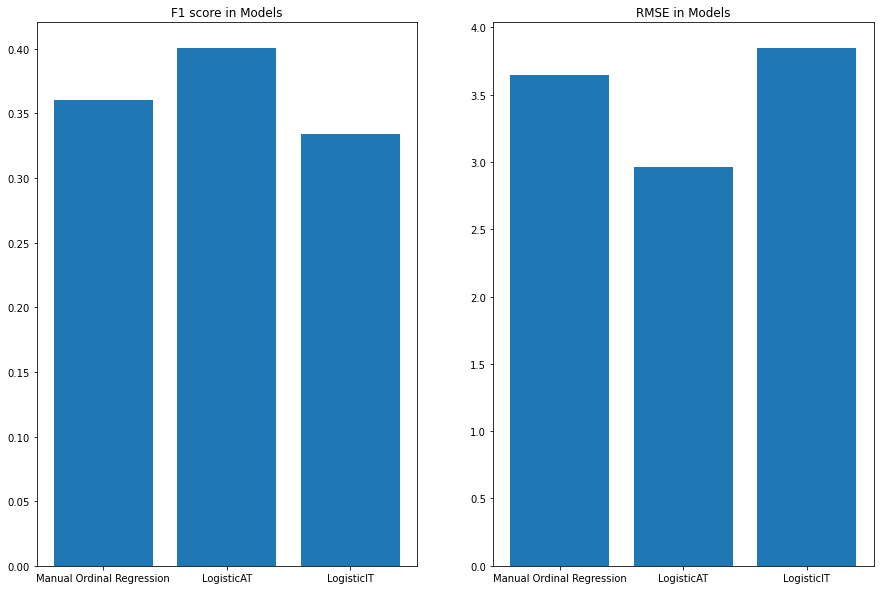

In [85]:
models=['Manual Ordinal Regression', 'LogisticAT', 'LogisticIT']
models_accuracy=[mean_accuracy_manual, mean_accuracy_auto, mean_accuracy_auto2]
models_mse=[mean_mse_manual, mean_mse_auto,mean_mse_auto2]
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,10))

ax1.bar(models, models_accuracy)
ax1.set_title('F1 score in Models')
ax2.bar(models, models_mse)
ax2.set_title('RMSE in Models')

Since the manual model has more parameters to tune, and gives us slightly better results for accuracy and RMSE values than LogisticIT and slightly worse than LogisticAT, I will move forward with using the manual ordinal logistic regression.

### Hyperparameter Tuning

#### Hyperparameter C

I tried decreasing the hyperparameter C to check the impact on F1 score and RMSE. The hyperparameter C represents the inverse of regularization strength, meaning if we reduce C, it increases the weight on regularization.

In [86]:
model4=LogisticRegression(C=0.05, solver='saga', random_state=42)
val_probabilities_manual2, fold_val_accuracy_manual2, fold_train_accuracy_manual2, mean_accuracy_manual2, var_accuracy_manual2, mean_mse_manual2, var_mse_manual2,fold_mse_manual2=ordinal_logistic_regression(model4)
print("Mean F1 score: {0}".format(mean_accuracy_manual2)) 
print("Variance: {0}".format(var_accuracy_manual2))
print("Mean RMSE: {0}".format(mean_mse_manual2)) 
print("Variance: {0}".format(var_mse_manual2))

Fold: 1  F1 score: 0.36075974053937593
Fold: 1  MSE: 3.581146799993094
Fold: 2  F1 score: 0.33248639134129065
Fold: 2  MSE: 3.924728239709994
Fold: 3  F1 score: 0.3643633815995765
Fold: 3  MSE: 3.4743064118823694
Fold: 4  F1 score: 0.3880012152654659
Fold: 4  MSE: 3.6524575519461124
Fold: 5  F1 score: 0.3501317212826417
Fold: 5  MSE: 3.8902250102604436
Fold: 6  F1 score: 0.3720974245815388
Fold: 6  MSE: 3.830805756614117
Fold: 7  F1 score: 0.35373412050012404
Fold: 7  MSE: 3.5185527401281123
Fold: 8  F1 score: 0.3504796610082693
Fold: 8  MSE: 3.647408497657972
Fold: 9  F1 score: 0.3602599822688731
Fold: 9  MSE: 3.5456015018187426
Fold: 10  F1 score: 0.3569445621354079
Fold: 10  MSE: 3.4437421280942133
Mean F1 score: 0.3589258200522564
Variance: 0.0001932176394935346
Mean RMSE: 3.650897463810517
Variance: 0.027220782223690232


In [87]:
model5=LogisticRegression(C=10, solver='saga', random_state=42)
val_probabilities_manual3, fold_val_accuracy_manual3, fold_train_accuracy_manual3, mean_accuracy_manual3, var_accuracy_manual3, mean_mse_manual3, var_mse_manual3,fold_mse_manual3=ordinal_logistic_regression(model5)
print("Mean F1 score: {0}".format(mean_accuracy_manual3)) 
print("Variance: {0}".format(var_accuracy_manual3))
print("Mean RMSE: {0}".format(mean_mse_manual3)) 
print("Variance: {0}".format(var_mse_manual3))

Fold: 1  F1 score: 0.361947553076359
Fold: 1  MSE: 3.5804702822199856
Fold: 2  F1 score: 0.33959671832920335
Fold: 2  MSE: 3.8913468130454065
Fold: 3  F1 score: 0.3683602996356753
Fold: 3  MSE: 3.436975866046012
Fold: 4  F1 score: 0.38786741016630066
Fold: 4  MSE: 3.657367038819598
Fold: 5  F1 score: 0.3506116500976583
Fold: 5  MSE: 3.9078870236140077
Fold: 6  F1 score: 0.37924173383355675
Fold: 6  MSE: 3.8051473637361033
Fold: 7  F1 score: 0.3550257944214018
Fold: 7  MSE: 3.507508918974096
Fold: 8  F1 score: 0.350079269000235
Fold: 8  MSE: 3.6512623542858997
Fold: 9  F1 score: 0.3580611594201946
Fold: 9  MSE: 3.579497604941612
Fold: 10  F1 score: 0.35848854243654044
Fold: 10  MSE: 3.449229942595335
Mean F1 score: 0.36092801304171257
Variance: 0.00018455546095204624
Mean RMSE: 3.646669320827806
Variance: 0.026456621328434786


Text(0.5, 1.0, 'RMSE in Models')

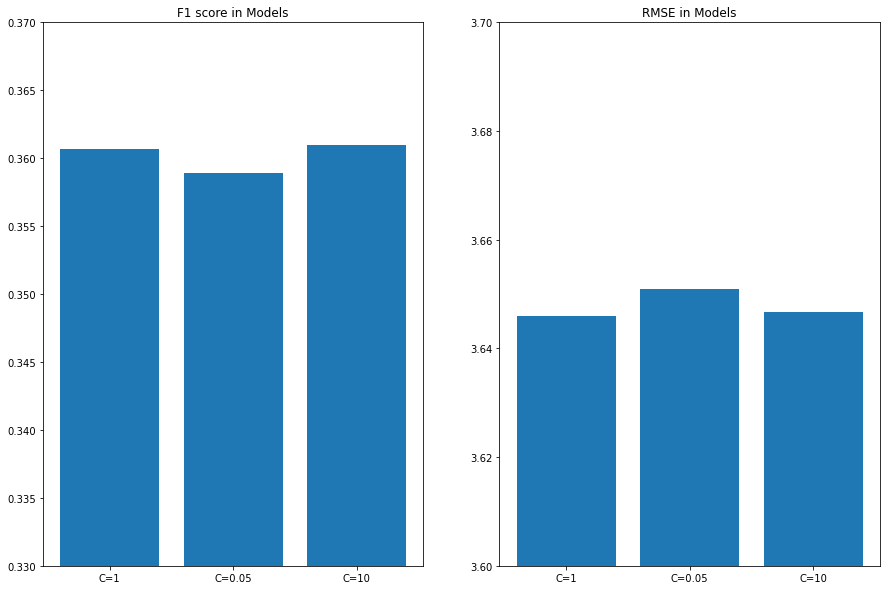

In [88]:
models2=['C=1', 'C=0.05', 'C=10']
models_accuracy2=[mean_accuracy_manual, mean_accuracy_manual2, mean_accuracy_manual3]
models_mse2=[mean_mse_manual, mean_mse_manual2,mean_mse_manual3]
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,10))

ax1.bar(models2, models_accuracy2)
ax1.set_ylim(0.33,0.37)
ax1.set_title('F1 score in Models')
ax2.bar(models2, models_mse2)
ax2.set_ylim(3.6,3.7)
ax2.set_title('RMSE in Models')

These graphs show that reducing C does not improve the model, both in terms of RMSE and accuracy, it actually makes it worse. However, increasing C slightly improved the model performance. Meaning reducing the weight on regularization made the model perform better. Regularization tries to find the best optimal midpoint between the bias and variance and that is through neither overfitting nor underfitting the model. The bias-variance tradeoff is related in the following sense: Regularizing too much can cause underfitting the model, which is what we can see in our models. (definitions of bias and variation are brought from the lecture). Note in this case, our regularization is Ridge and not Lasso (default value of LogisticRegression()).
- Bias is how much predicted values differ from true values. To achieve a lower bias, we need to make our expected predicted values closer to the true values, and this can be considered as having a lower RMSE. Notice in our graphs, the more we increase the importance of regularization (c=0.05), the higher our RMSE value was. Therefore, increasing our C value caused underfitting.
- Variance is how predictions made on the same value vary on different realizations of the model. It is expected if we lower the importance of regularization, the variance will be higher because the model will be more complex (might overfit). However, this was not the case, since we performed Lasso previously, this might have been enough for the model to avoid overfitting, and thus relaxing this ridge regularization term would actually benefit the model (notice higher C leads to slightly better results).

In [89]:
def plot_learning_curve(title, train_accuracy, validation_accuracy):
    
    plt.figure(figsize=(10,6))
    plt.title(title)

    
    plt.plot(np.arange(0,10,1), train_accuracy, 'o-', color="r",label="Training accuracy")
    plt.plot(np.arange(0,10,1), validation_accuracy, 'o-', color="g", label="Validation accuracy")
    plt.legend(loc="best")
    
    return plt

<module 'matplotlib.pyplot' from '/Applications/anaconda3/lib/python3.9/site-packages/matplotlib/pyplot.py'>

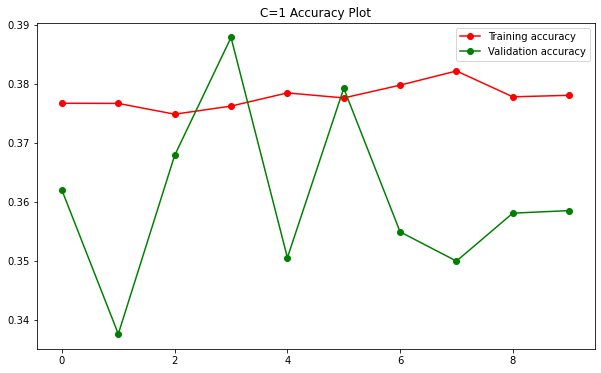

In [90]:
plot_learning_curve('C=1 Accuracy Plot', fold_train_accuracy_manual, fold_val_accuracy_manual)

<module 'matplotlib.pyplot' from '/Applications/anaconda3/lib/python3.9/site-packages/matplotlib/pyplot.py'>

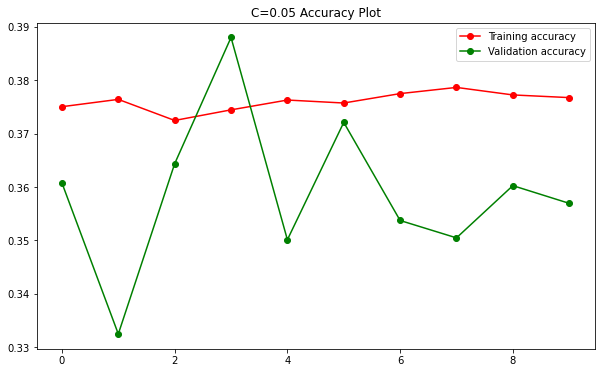

In [91]:
plot_learning_curve('C=0.05 Accuracy Plot', fold_train_accuracy_manual2, fold_val_accuracy_manual2)

<module 'matplotlib.pyplot' from '/Applications/anaconda3/lib/python3.9/site-packages/matplotlib/pyplot.py'>

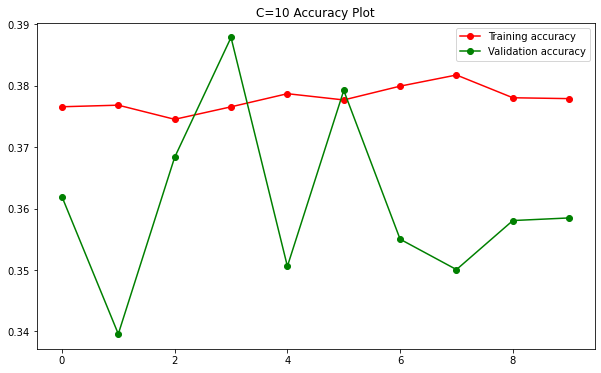

In [92]:
plot_learning_curve('C=10 Accuracy Plot', fold_train_accuracy_manual3, fold_val_accuracy_manual3)

Notice that in the second curve, where regularization is given more weight, the F1 scores are slightly smoother for the training curve, meaning variance has been reduced, however, the F1 scores for both validation and training are slightly worse than the other two graphs. This shows that we underfitted our model more than when the C value is higher.

Reducing the importance (increasing the value of C) slightly makes the curves better, but this is not too visible. If we compare the values numerically, it shows better.

#### Hyperparameter penalty

Now, I will compare the influence of the type of regularization. L1 regularization encourages zero coefficients to some features, while L2 regularization only shrinks the coefficients of the features.

In [93]:
model6=LogisticRegression(penalty='l1', solver='saga', random_state=42)
val_probabilities_manual4, fold_val_accuracy_manual4, fold_train_accuracy_manual4, mean_accuracy_manual4, var_accuracy_manual4, mean_mse_manual4, var_mse_manual4,fold_mse_manual4=ordinal_logistic_regression(model6)
print("Mean F1 score: {0}".format(mean_accuracy_manual4)) 
print("Variance: {0}".format(var_accuracy_manual4))
print("Mean RMSE: {0}".format(mean_mse_manual4)) 
print("Variance: {0}".format(var_mse_manual4))

Fold: 1  F1 score: 0.3620042085771509
Fold: 1  MSE: 3.57776293190301
Fold: 2  F1 score: 0.3363494549050565
Fold: 2  MSE: 3.8886040571256526
Fold: 3  F1 score: 0.36703342749435397
Fold: 3  MSE: 3.463261527429236
Fold: 4  F1 score: 0.3865149357384699
Fold: 4  MSE: 3.6610779499454953
Fold: 5  F1 score: 0.350463375424122
Fold: 5  MSE: 3.888229895052481
Fold: 6  F1 score: 0.3775006554595389
Fold: 6  MSE: 3.792508824166043
Fold: 7  F1 score: 0.35344697206762493
Fold: 7  MSE: 3.51441537412988
Fold: 8  F1 score: 0.34757789020281593
Fold: 8  MSE: 3.6507310297262934
Fold: 9  F1 score: 0.35734137879010247
Fold: 9  MSE: 3.5535258647961148
Fold: 10  F1 score: 0.35999067763540427
Fold: 10  MSE: 3.443882950524831
Mean F1 score: 0.35982229762946394
Variance: 0.00019170997638719747
Mean RMSE: 3.6434000404799036
Variance: 0.024394594342685077


Text(0.5, 1.0, 'RMSE in Models')

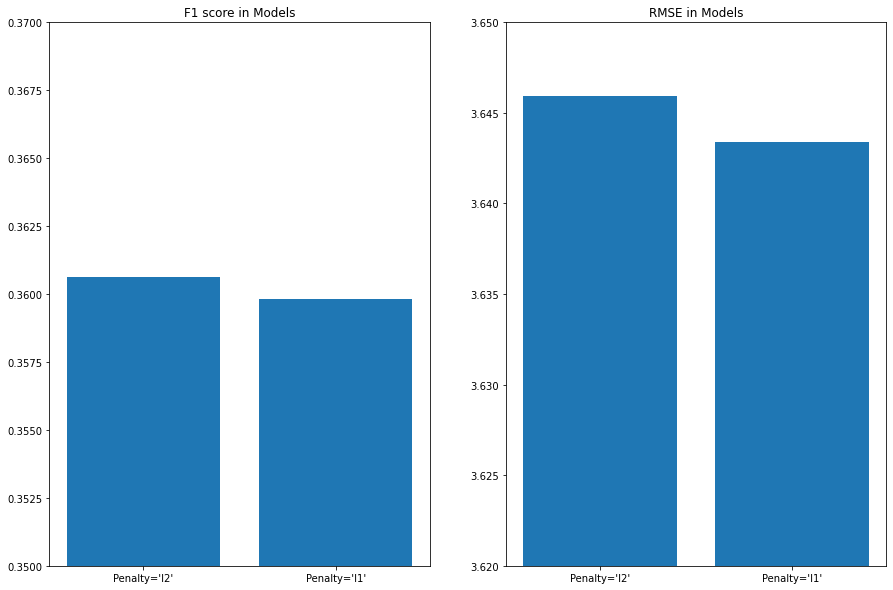

In [94]:
models3=["Penalty='l2'", "Penalty='l1'"]
models_accuracy3=[mean_accuracy_manual, mean_accuracy_manual4]
models_mse3=[mean_mse_manual,mean_mse_manual4]
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,10))

ax1.bar(models3, models_accuracy3)
ax1.set_ylim(0.35,0.37)
ax1.set_title('F1 score in Models')
ax2.bar(models3, models_mse3)
ax2.set_ylim(3.62,3.65)
ax2.set_title('RMSE in Models')

These graphs show the impact of the type of regularization applied and how it affects the models.

Since I previously did feature selection, logically, applying L1 regularization and removing some features will result in having less features, meaning more bias. The F1 score is worse. This could be caused by underfitting the model. If we have too much regularization, the model will not be performing properly anymore, as it does not have enough features to predict the target from.

#### Hyperparameter max_iter

I will check if the number of iterations to converge affects the performance of our model.

In [95]:
model7=LogisticRegression(max_iter=50, solver='saga', random_state=42)
val_probabilities_manual5, fold_val_accuracy_manual5, fold_train_accuracy_manual5, mean_accuracy_manual5, var_accuracy_manual5, mean_mse_manual5, var_mse_manual5,fold_mse_manual5=ordinal_logistic_regression(model7)
print("Mean F1 score: {0}".format(mean_accuracy_manual5)) 
print("Variance: {0}".format(var_accuracy_manual5))
print("Mean RMSE: {0}".format(mean_mse_manual5)) 
print("Variance: {0}".format(var_mse_manual5))

Fold: 1  F1 score: 0.361947553076359
Fold: 1  MSE: 3.5804702822199856
Fold: 2  F1 score: 0.33755971553742803
Fold: 2  MSE: 3.891845288268491
Fold: 3  F1 score: 0.36786337128777247
Fold: 3  MSE: 3.4402196938846865
Fold: 4  F1 score: 0.38786741016630066
Fold: 4  MSE: 3.6569692178537374
Fold: 5  F1 score: 0.35051078220778314
Fold: 5  MSE: 3.8980708501841375
Fold: 6  F1 score: 0.37924173383355675
Fold: 6  MSE: 3.8051473637361033
Fold: 7  F1 score: 0.3548806857429538
Fold: 7  MSE: 3.51041128514632
Fold: 8  F1 score: 0.3499249209658195
Fold: 8  MSE: 3.6476744115939255
Fold: 9  F1 score: 0.3580611594201946
Fold: 9  MSE: 3.579497604941612
Fold: 10  F1 score: 0.35848854243654044
Fold: 10  MSE: 3.449229942595335
Mean F1 score: 0.36063458746747085
Variance: 0.00019358052525908623
Mean RMSE: 3.645953594042434
Variance: 0.025759561045235257


In [96]:
model8=LogisticRegression(max_iter=150, solver='saga', random_state=42)
val_probabilities_manual6, fold_val_accuracy_manual6, fold_train_accuracy_manual6, mean_accuracy_manual6, var_accuracy_manual6, mean_mse_manual6, var_mse_manual6,fold_mse_manual6=ordinal_logistic_regression(model8)
print("Mean F1 score: {0}".format(mean_accuracy_manual6)) 
print("Variance: {0}".format(var_accuracy_manual6))
print("Mean RMSE: {0}".format(mean_mse_manual6)) 
print("Variance: {0}".format(var_mse_manual6))

Fold: 1  F1 score: 0.361947553076359
Fold: 1  MSE: 3.5804702822199856
Fold: 2  F1 score: 0.33755971553742803
Fold: 2  MSE: 3.891845288268491
Fold: 3  F1 score: 0.36786337128777247
Fold: 3  MSE: 3.4402196938846865
Fold: 4  F1 score: 0.38786741016630066
Fold: 4  MSE: 3.6569692178537374
Fold: 5  F1 score: 0.35051078220778314
Fold: 5  MSE: 3.8980708501841375
Fold: 6  F1 score: 0.37924173383355675
Fold: 6  MSE: 3.8051473637361033
Fold: 7  F1 score: 0.3548806857429538
Fold: 7  MSE: 3.51041128514632
Fold: 8  F1 score: 0.3499249209658195
Fold: 8  MSE: 3.6476744115939255
Fold: 9  F1 score: 0.3580611594201946
Fold: 9  MSE: 3.579497604941612
Fold: 10  F1 score: 0.35848854243654044
Fold: 10  MSE: 3.449229942595335
Mean F1 score: 0.36063458746747085
Variance: 0.00019358052525908623
Mean RMSE: 3.645953594042434
Variance: 0.025759561045235257


Text(0.5, 1.0, 'RMSE in Models')

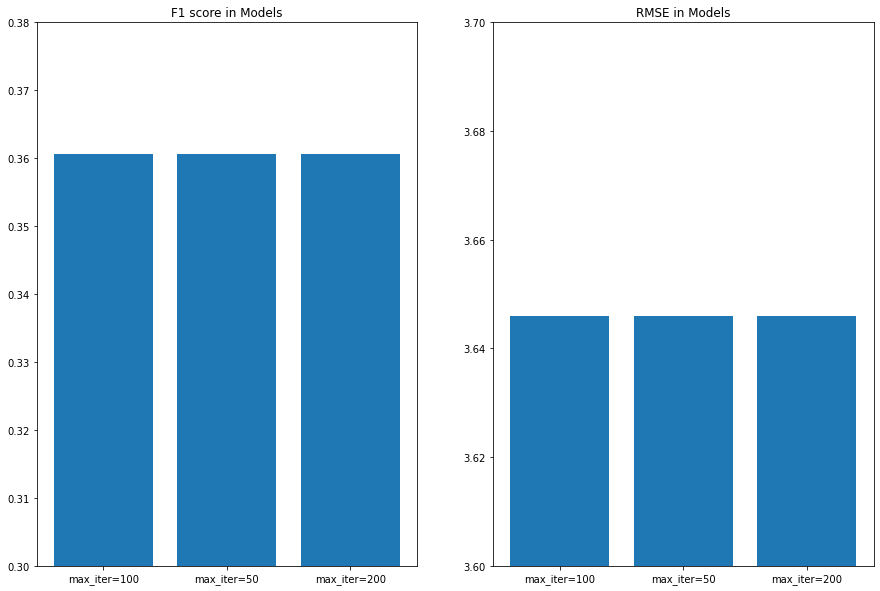

In [97]:
models4=["max_iter=100", "max_iter=50", "max_iter=200"]
models_accuracy4=[mean_accuracy_manual, mean_accuracy_manual5,mean_accuracy_manual6]
models_mse4=[mean_mse_manual,mean_mse_manual5,mean_mse_manual6]
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,10))

ax1.bar(models4, models_accuracy4)
ax1.set_ylim(0.3,0.38)
ax1.set_title('F1 score in Models')
ax2.bar(models4, models_mse4)
ax2.set_ylim(3.6,3.7)
ax2.set_title('RMSE in Models')

By looking at the above graphs, the solver converges when we decrease or increase our max_iter. Therefore, this has no effect and will not be considered for the analysis of the hyperparameter tuning. Note: if we decrease the max iterations further, it will make the performance worse, because we are selecting predictions before the solver converges.

#### Hyperparameter class_weight

As previously seen, the target classes have very different counts, meaning the dataset is imbalanced, so class_weight parameter has the option of setting 'balanced' as taking into account the frequence of each class label.

In [98]:
model9=LogisticRegression(class_weight='balanced', solver='saga', random_state=42)
val_probabilities_manual7, fold_val_accuracy_manual7, fold_train_accuracy_manual7, mean_accuracy_manual7, var_accuracy_manual7, mean_mse_manual7, var_mse_manual7,fold_mse_manual7=ordinal_logistic_regression(model9)
print("Mean F1 score: {0}".format(mean_accuracy_manual7)) 
print("Variance: {0}".format(var_accuracy_manual7))
print("Mean RMSE: {0}".format(mean_mse_manual7)) 
print("Variance: {0}".format(var_mse_manual7))

Fold: 1  F1 score: 0.3320481639373174
Fold: 1  MSE: 6.196867175492604
Fold: 2  F1 score: 0.3076334853626861
Fold: 2  MSE: 6.759983815314736
Fold: 3  F1 score: 0.33313843717005215
Fold: 3  MSE: 6.570368187425398
Fold: 4  F1 score: 0.3335820812829506
Fold: 4  MSE: 6.776320956330269
Fold: 5  F1 score: 0.2920141167525015
Fold: 5  MSE: 6.951543520901483
Fold: 6  F1 score: 0.33588287418249824
Fold: 6  MSE: 6.439903488020185
Fold: 7  F1 score: 0.30686009147513105
Fold: 7  MSE: 6.869434966605825
Fold: 8  F1 score: 0.3162983633424744
Fold: 8  MSE: 6.2535344031613675
Fold: 9  F1 score: 0.31621963168179
Fold: 9  MSE: 6.557290609374461
Fold: 10  F1 score: 0.30777478421699567
Fold: 10  MSE: 6.868022868215547
Mean F1 score: 0.31814520294043963
Variance: 0.00020063594294502155
Mean RMSE: 6.624326999084188
Variance: 0.06296676916638667


Text(0.5, 1.0, 'RMSE in Models')

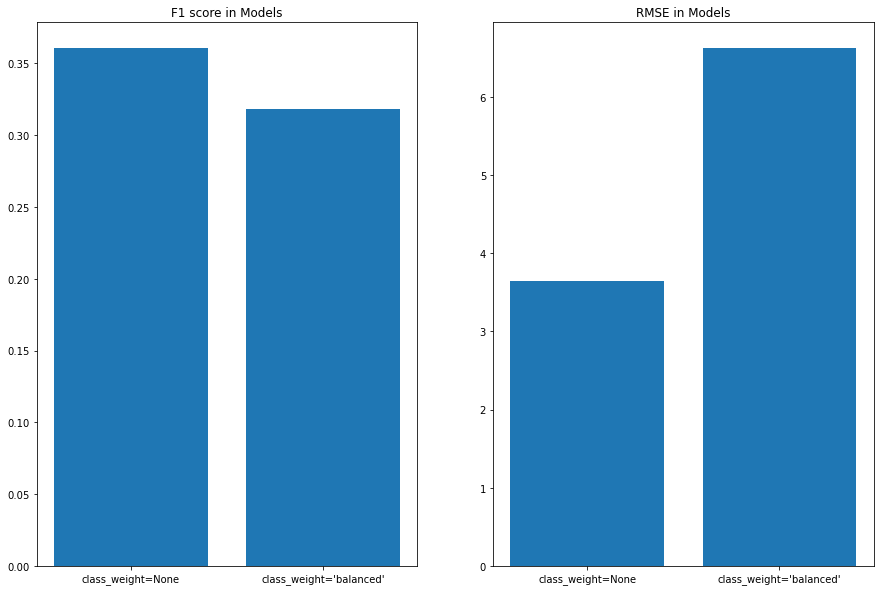

In [99]:
models5=["class_weight=None", "class_weight='balanced'"]
models_accuracy5=[mean_accuracy_manual,mean_accuracy_manual7]
models_mse5=[mean_mse_manual,mean_mse_manual7]
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,10))

ax1.bar(models5, models_accuracy5)
ax1.set_title('F1 score in Models')
ax2.bar(models5, models_mse5)
ax2.set_title('RMSE in Models')

Although I expected having class_weight='balanced' would improve the predictions, turns out it makes them worse. This could be because of the nature of the ordinal regression: every logistic regression gives a different weight to the classes, (for example, in the first model, we have label 0 as class 0 only, and all the other labels as class 1, in the second model, labels 0 and 1 are class 0, while the others are class 1...). This change in weights can affect the model negatively.

## Model Tuning

As seen in question 3, the two hyperparameters that truly had an impact on the performance of the model. The hyperparameters of the LogisticRegression() model are:
- C (already mentioned what it is for)
- solver
- penalty
- tolerance
- fit_intercept
- intercept_scaling
- class_weight
- max_iter
- l1_ratio

I only selected C and penalty, since these two can be paired together and potentially have a different outcome that is optimal, other than the optimal value of each one of them separately. For example, having L1 with a C=0.75 could be better than our baseline.

Therefore, I decided to tune these two hyperparameters. Since the model is made from scratch, I did the grid search manually, where I iterated over every combination and calculated the F1 score and rmse of each one of them. However, note that I limited the C values to only 4 due to time constraints.

In [100]:
accuracy_values={}
mse_values={}

penalty=['l1', 'l2']
C=[0.75,1, 10, 15]

for i in penalty:
    for j in C:
        model=LogisticRegression(penalty=i, C=j, solver='saga', random_state=42)
        val_probabilities, fold_val_acc, fold_train_acc, mean_acc, var_acc, mean_mse, var_mse, fold_mse=ordinal_logistic_regression(model)
        
        if (i,j) in accuracy_values:
            accuracy_values[(i,j)].append(mean_acc)
            
        else:
            accuracy_values[(i,j)] = mean_acc
            
        if (i,j) in mse_values:
            mse_values[(i,j)].append(mean_mse)
            
        else:
            mse_values[(i,j)] = mean_mse
            
            

print(accuracy_values)
print(mse_values)

Fold: 1  F1 score: 0.36275802583443606
Fold: 1  MSE: 3.5753245637891546
Fold: 2  F1 score: 0.33604500924281766
Fold: 2  MSE: 3.8772384104619606
Fold: 3  F1 score: 0.3686384299043702
Fold: 3  MSE: 3.463121492998294
Fold: 4  F1 score: 0.38469052691665756
Fold: 4  MSE: 3.677071326511383
Fold: 5  F1 score: 0.3497962399105613
Fold: 5  MSE: 3.888354619744009
Fold: 6  F1 score: 0.3782552557033457
Fold: 6  MSE: 3.800811593355586
Fold: 7  F1 score: 0.35351163420794174
Fold: 7  MSE: 3.5140013696079015
Fold: 8  F1 score: 0.34735160038079005
Fold: 8  MSE: 3.6621375195935952
Fold: 9  F1 score: 0.3585313512222877
Fold: 9  MSE: 3.5438229205672136
Fold: 10  F1 score: 0.35838216523167177
Fold: 10  MSE: 3.4445869763208736
Fold: 1  F1 score: 0.3620042085771509
Fold: 1  MSE: 3.57776293190301
Fold: 2  F1 score: 0.3363494549050565
Fold: 2  MSE: 3.8886040571256526
Fold: 3  F1 score: 0.36703342749435397
Fold: 3  MSE: 3.463261527429236
Fold: 4  F1 score: 0.3865149357384699
Fold: 4  MSE: 3.6610779499454953
Fold

I selected F1 score as my metric, because as I explained previously, it helps with imbalanced data, and it also helps with not only looking at how many right predictions we have, but rather helps balance the metrics of recall and precision.

In [101]:
values=list(accuracy_values.values())
keys=list(accuracy_values.keys())
maximum=values.index(max(accuracy_values.values()))
keys[maximum]

('l2', 10)

Because I set the random_state to 42 in the RandomForestClassifier, the optimal combinatioon is penalty='l2', C=10, which maximizes our F1 score.

In [102]:
final_model=LogisticRegression(penalty=keys[maximum][0], C=keys[maximum][1],solver='saga', random_state=42)
final_val_probabilities, final_fold_val_accuracy, final_fold_train_accuracy, final_mean_accuracy, final_var_accuracy, final_mean_mse, final_var_mse, final_fold_mse=ordinal_logistic_regression(final_model)
print("Mean F1 score: {0}".format(final_mean_accuracy)) 
print("Variance: {0}".format(final_var_accuracy))

Fold: 1  F1 score: 0.361947553076359
Fold: 1  MSE: 3.5804702822199856
Fold: 2  F1 score: 0.33959671832920335
Fold: 2  MSE: 3.8913468130454065
Fold: 3  F1 score: 0.3683602996356753
Fold: 3  MSE: 3.436975866046012
Fold: 4  F1 score: 0.38786741016630066
Fold: 4  MSE: 3.657367038819598
Fold: 5  F1 score: 0.3506116500976583
Fold: 5  MSE: 3.9078870236140077
Fold: 6  F1 score: 0.37924173383355675
Fold: 6  MSE: 3.8051473637361033
Fold: 7  F1 score: 0.3550257944214018
Fold: 7  MSE: 3.507508918974096
Fold: 8  F1 score: 0.350079269000235
Fold: 8  MSE: 3.6512623542858997
Fold: 9  F1 score: 0.3580611594201946
Fold: 9  MSE: 3.579497604941612
Fold: 10  F1 score: 0.35848854243654044
Fold: 10  MSE: 3.449229942595335
Mean F1 score: 0.36092801304171257
Variance: 0.00018455546095204624


(0.355, 0.363)

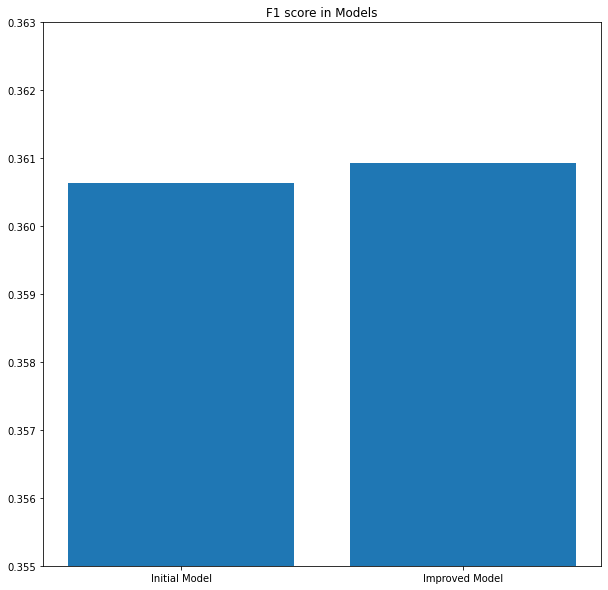

In [103]:
models6=["Initial Model", "Improved Model"]
models_accuracy6=[mean_accuracy_manual,final_mean_accuracy]
models_mse6=[mean_mse_manual,final_mean_mse]

plt.figure(figsize=(10,10))

plt.bar(models6, models_accuracy6)
plt.title('F1 score in Models')
plt.ylim(0.355, 0.363)

We have 14 models of logistic regression, the importance of the features will be the average of the coefficients in all the models.

In [104]:
coef=np.zeros((14,len(filtered_X_df.columns)))
for i in range (14):
    pickle_model = pickle.load(open("model {0}.pkl".format(i), 'rb'))
    coef[i,:]=pickle_model.coef_[0]
    
coef

array([[ 4.13888183e-01,  3.99431256e-01, -1.96199187e-02,
        -7.61173264e-02, -9.96661279e-02, -3.86433196e-02,
         5.75487494e-02,  1.95882775e-02, -3.06420682e-02,
        -2.52242010e-02, -1.08929374e-02,  8.68561136e-02,
        -8.48464307e-02, -2.39192927e-02, -7.07215504e-02,
        -7.50526770e-02, -9.73730030e-02,  2.87002529e-02,
         2.39853621e-02,  1.64812092e-02,  4.58156445e-02,
         3.75015894e-02,  1.22664205e-01,  5.43294811e-02,
         3.49477209e-01,  1.42376681e-01,  1.18957336e-01,
        -9.31536212e-03,  3.61365342e-01, -1.84748516e-03,
         2.64672173e-02,  7.62707373e-02, -1.57236394e-01,
         6.77793991e-02, -1.52847939e-02,  8.41132554e-02,
        -6.17899001e-02, -6.27344667e-02, -2.75723903e-03,
         1.56660538e-01,  1.24658820e-01, -1.01691646e-01,
        -4.83140508e-02, -1.73729681e-02, -1.56661381e-02,
        -1.17432927e-01, -2.40093824e-01,  5.08351233e-01,
        -9.50191697e-04,  1.59499575e-01,  1.14617565e-0

In [105]:
feature_importance=np.mean(coef,axis=0)
feature_importance_df=pd.DataFrame (feature_importance, index=filtered_X_df.columns ,columns=['Feature Importance'])
feature_importance_df

,Feature Importance
Q1,0.402473
Q6,0.316050
Q7_Part_3,-0.060598
Q7_Part_4,-0.072456
Q7_Part_5,-0.004041
...,...
Q20_Accounting/Finance,0.058166
Q20_Manufacturing/Fabrication,0.005046
Q23_No (we do not use ML methods),-0.061971
Q23_We are exploring ML methods (and may one day put a model into production),0.019901


Text(0.5, 1.0, 'Feature importance')

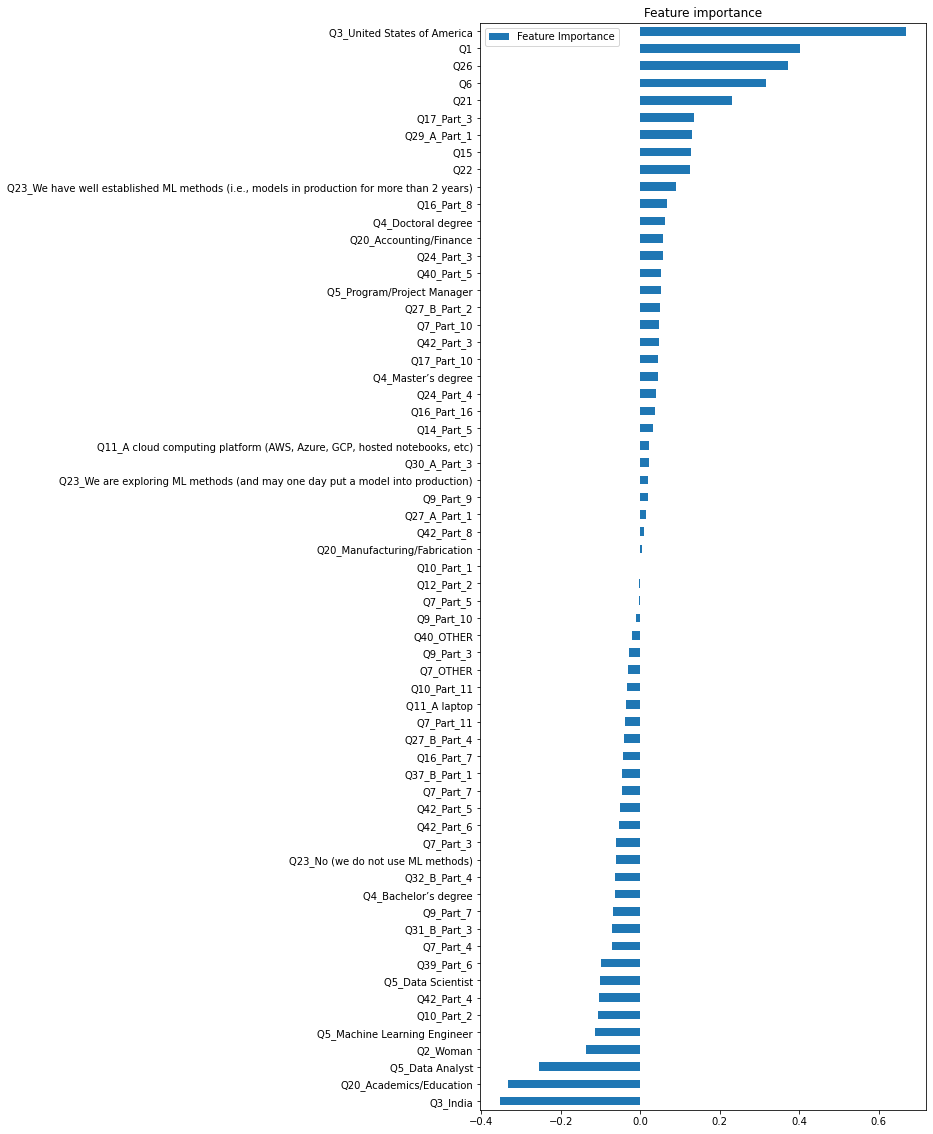

In [106]:
sorted_fi = feature_importance_df.sort_values(by='Feature Importance')
plt.rcParams['figure.figsize'] = (8.0, 20.0)
ax=sorted_fi.plot(kind = "barh")
ax.set_yticks(range(0,sorted_fi.shape[0]))
plt.title("Feature importance")

Notice that the feature importance plot is very similar to the one found in part 2. This means the model fit the features properly with respect to their correlation with the target variable.

## Testing

Now that the optimal models are saved to file, I will import them and predict both the training and testing F1 score and RMSE. 

Note, I will not be doing them in folds, since I do not want the testing data to be seen before by the model.

In [107]:
def testing_ordinal(X_train, y_train, X_test, y_test):
    
    test_p=np.zeros((len(X_test),len(y_test['Q25_Encoded'].unique())))
    train_p=np.zeros((len(X_train),len(y_train['Q25_Encoded'].unique())))


    for j in range(test_p.shape[1]):
        if j==0:
            pickle_model = pickle.load(open("model {0}.pkl".format(j), 'rb'))
            test_p[:,j]=pickle_model.predict_proba(X_test)[:,0]
            train_p[:,j]=pickle_model.predict_proba(X_train)[:,0]
        elif j==(test_p.shape[1]-1):
            pickle_model = pickle.load(open("model {0}.pkl".format(len(y_test['Q25_Encoded'].unique())-2), 'rb'))
            test_p[:,j]=pickle_model.predict_proba(X_test)[:,1]
            train_p[:,j]=pickle_model.predict_proba(X_train)[:,1]
        else:
            pickle_model = pickle.load(open("model {0}.pkl".format(j), 'rb'))
            previous_pickle_model= pickle.load(open("model {0}.pkl".format(j-1), 'rb'))
            test_p[:,j]=np.maximum((pickle_model.predict_proba(X_test)[:,0]-previous_pickle_model.predict_proba(X_test)[:,0]),0)
            train_p[:,j]=np.maximum((pickle_model.predict_proba(X_train)[:,0]-previous_pickle_model.predict_proba(X_train)[:,0]),0)

        
    test_predictions=np.argmax(test_p,axis=1)
    train_predictions=np.argmax(train_p,axis=1)
    test_accuracy=(f1_score(y_test, test_predictions, average='weighted'))
    train_accuracy=(f1_score(y_train, train_predictions, average='weighted'))
    train_mse=(mean_squared_error(y_train, train_predictions, squared=False))
    test_mse=(mean_squared_error(y_test, test_predictions, squared=False))
    
    
    return test_p, train_p, test_predictions, train_predictions, test_accuracy, train_accuracy, train_mse, test_mse

In [108]:
X_test_scaled=scaler.transform(X_test)
X_test_scaled_df=pd.DataFrame(X_test_scaled,columns=X_test.columns)
X_test_scaled_df=X_test_scaled_df[filtered_X_df.columns]
X_test_scaled_df

,Q1,Q6,Q7_Part_3,Q7_Part_4,Q7_Part_5,Q7_Part_7,Q7_Part_10,Q7_Part_11,Q7_OTHER,Q9_Part_3,...,Q5_Machine Learning Engineer,Q5_Program/Project Manager,"Q11_A cloud computing platform (AWS, Azure, GCP, hosted notebooks, etc)",Q11_A laptop,Q20_Academics/Education,Q20_Accounting/Finance,Q20_Manufacturing/Fabrication,Q23_No (we do not use ML methods),Q23_We are exploring ML methods (and may one day put a model into production),"Q23_We have well established ML methods (i.e., models in production for more than 2 years)"
0,0.231167,-0.557158,-0.924931,-0.38665,-0.432373,-0.443226,-0.350654,-0.333136,-0.379826,-0.424126,...,-0.30981,4.361348,-0.351351,0.757442,-0.490708,-0.311874,-0.242573,-0.510707,1.901444,-0.438362
1,-1.079204,-0.557158,-0.924931,-0.38665,-0.432373,-0.443226,-0.350654,-0.333136,-0.379826,-0.424126,...,-0.30981,-0.229287,-0.351351,0.757442,-0.490708,3.206428,-0.242573,-0.510707,-0.525916,2.281221
2,-0.205623,-1.712948,-0.924931,-0.38665,-0.432373,-0.443226,-0.350654,-0.333136,-0.379826,-0.424126,...,-0.30981,-0.229287,-0.351351,0.757442,-0.490708,-0.311874,-0.242573,-0.510707,-0.525916,-0.438362
3,1.541538,1.176527,-0.924931,-0.38665,2.312820,-0.443226,-0.350654,-0.333136,-0.379826,-0.424126,...,-0.30981,-0.229287,-0.351351,0.757442,2.037872,-0.311874,-0.242573,1.958070,-0.525916,-0.438362
4,0.667957,-0.557158,-0.924931,-0.38665,-0.432373,-0.443226,-0.350654,-0.333136,-0.379826,-0.424126,...,-0.30981,-0.229287,-0.351351,-1.320234,-0.490708,3.206428,-0.242573,-0.510707,-0.525916,2.281221
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5075,0.231167,0.020737,-0.924931,-0.38665,-0.432373,-0.443226,-0.350654,-0.333136,-0.379826,-0.424126,...,-0.30981,-0.229287,-0.351351,0.757442,-0.490708,-0.311874,-0.242573,1.958070,-0.525916,-0.438362
5076,-1.079204,0.020737,1.081162,-0.38665,-0.432373,-0.443226,-0.350654,-0.333136,-0.379826,-0.424126,...,-0.30981,-0.229287,-0.351351,0.757442,-0.490708,-0.311874,-0.242573,-0.510707,1.901444,-0.438362
5077,0.667957,1.754422,1.081162,-0.38665,-0.432373,2.256185,2.851817,-0.333136,2.632782,2.357787,...,-0.30981,-0.229287,-0.351351,0.757442,-0.490708,-0.311874,-0.242573,-0.510707,1.901444,-0.438362
5078,-0.642413,-1.135053,1.081162,-0.38665,-0.432373,-0.443226,-0.350654,-0.333136,-0.379826,-0.424126,...,-0.30981,-0.229287,-0.351351,-1.320234,-0.490708,-0.311874,-0.242573,-0.510707,1.901444,-0.438362


In [109]:
test_p, train_p, test_predictions, train_predictions, test_accuracy, train_accuracy, train_mse, test_mse = testing_ordinal(filtered_X_df, filtered_y_df, X_test_scaled_df, y_test)

(2.0, 4.0)

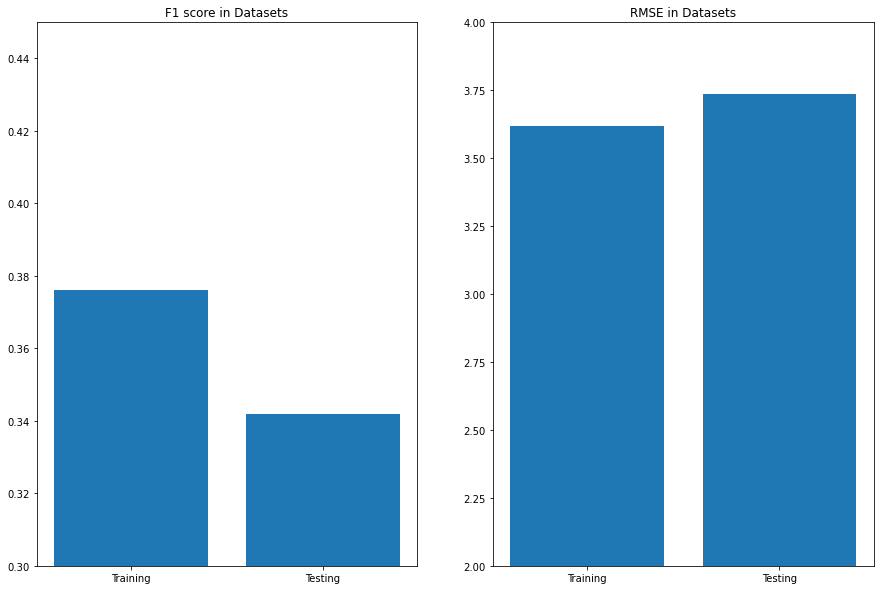

In [110]:
models7=["Training", "Testing"]
models_accuracy7=[train_accuracy,test_accuracy]
models_mse7=[train_mse,test_mse]
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,10))

ax1.bar(models7, models_accuracy7)
ax1.set_title('F1 score in Datasets')
ax1.set_ylim(0.3,0.45)
ax2.bar(models7, models_mse7)
ax2.set_title('RMSE in Datasets')
ax2.set_ylim(2,4)

The testing F1 score is lower than our training F1 score, while the RMSE value is higher. This is normal, since the training datasets have been seen before. Since the difference in F1 score is only 0.03 (6% less), I do not consider this to be overfitting, the model was still performing relatively the same on both datasets.

In [111]:
values_test_predictions,count_test_predictions=np.unique(test_predictions, return_counts=True)
values_train_predictions,count_train_predictions=np.unique(train_predictions, return_counts=True)
values_test_actual,count_test_actual=np.unique(np.array(y_test).reshape(-1), return_counts=True)
values_train_actual,count_train_actual=np.unique(np.array(filtered_y_df).reshape(-1), return_counts=True)

Text(0.5, 1.0, 'Actual Training Count Distribution')

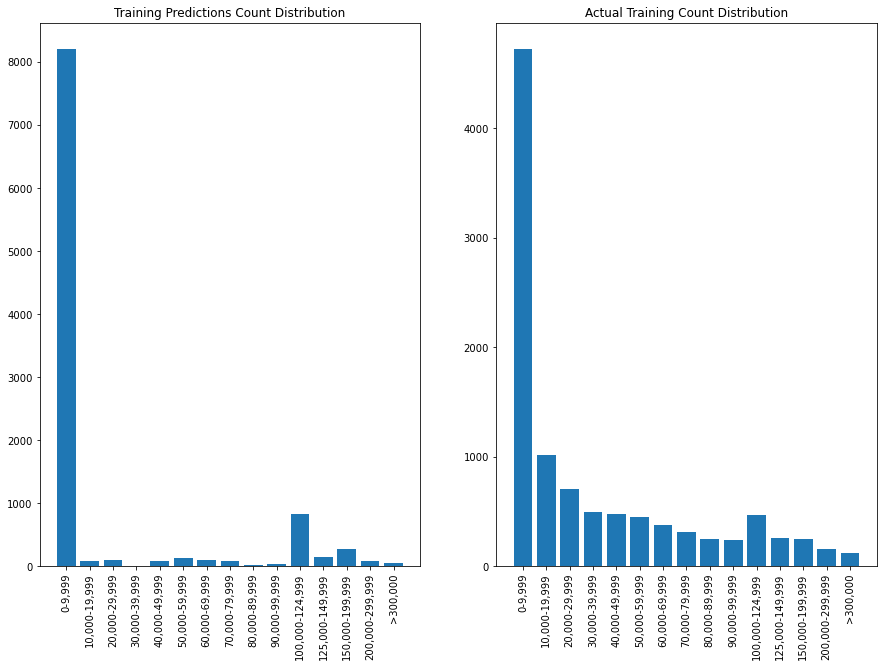

In [112]:
fig, (ax1, ax2)= plt.subplots(1, 2, figsize=(15,10))

ax1.bar(salary_buckets, height=count_train_predictions)
ax1.set_xticklabels(salary_buckets, rotation=90)
ax1.set_title("Training Predictions Count Distribution")
ax2.bar(salary_buckets, height=count_train_actual)
ax2.set_xticklabels(salary_buckets, rotation=90)
ax2.set_title("Actual Training Count Distribution")

Text(0.5, 1.0, 'Actual Testing Count Distribution')

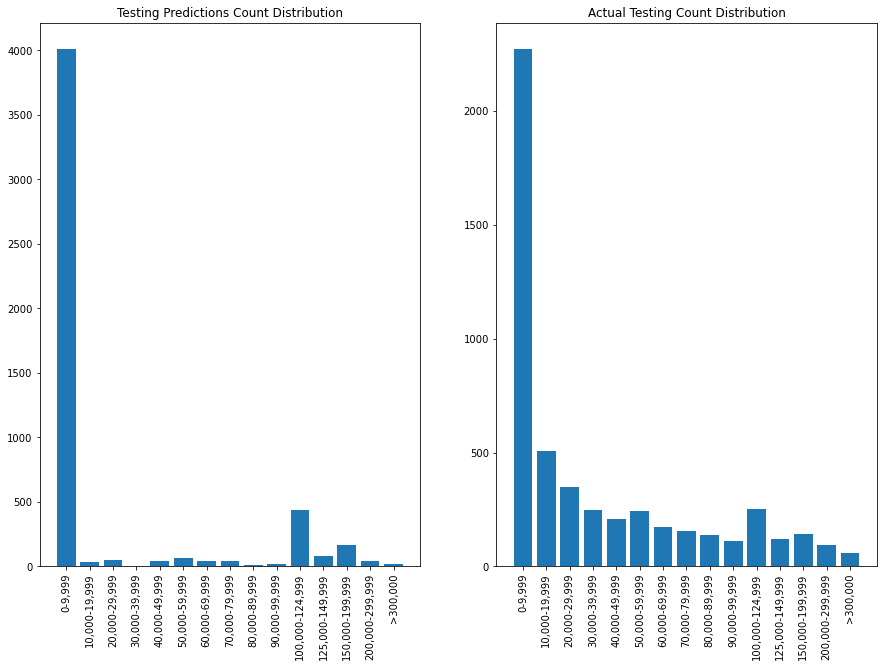

In [113]:
fig, (ax1, ax2)= plt.subplots(1, 2, figsize=(15,10))

ax1.bar(salary_buckets, height=count_test_predictions)
ax1.set_xticklabels(salary_buckets, rotation=90)
ax1.set_title("Testing Predictions Count Distribution")
ax2.bar(salary_buckets, height=count_test_actual)
ax2.set_xticklabels(salary_buckets, rotation=90)
ax2.set_title("Actual Testing Count Distribution")

In both plots, the predictions for some classes (buckets 0-9,999, 100,000-124,999, and 150,000-199,999) are relatively good, however the other counts are not well predicted.

Finally, I plotted the confusion matrices for both training and testing datasets to show how each class was predicted, its true positives, false negatives, and true positives.

In [114]:
confusion_train=confusion_matrix(train_predictions, filtered_y_df, labels=values_test_predictions)
confusion_test=confusion_matrix(test_predictions, y_test, labels=values_test_predictions)

Text(0.5, 1.0, 'Testing Confusion Matrix')

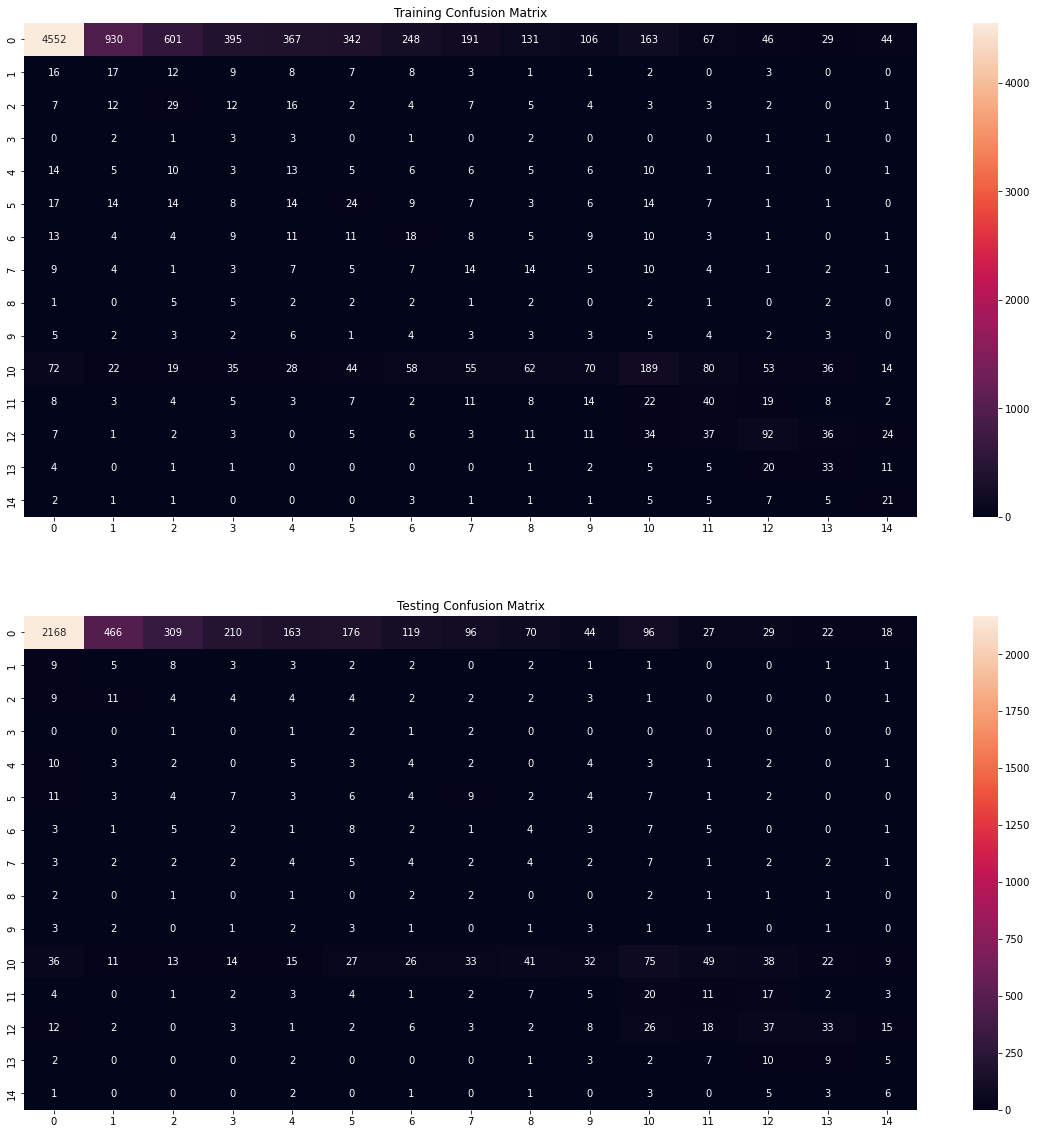

In [115]:
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(20,20))
sns.heatmap(confusion_train, annot=True, fmt='g', ax=ax1, )
ax1.set_title('Training Confusion Matrix')
sns.heatmap(confusion_test, annot=True, fmt='g', ax=ax2)
ax2.set_title('Testing Confusion Matrix')

Classes 0 and 10 are predicted well in both, and comparing it with what we previously saw in the above count graphs, these two classes correspond to the buckets 0-9,999 and 100,000-124,999, confirming once again that our model is predicting them well.

What I learned from this dataset and my trained classification model is:

- Having imbalanced datasets will make the model learn some classes more than others.
- Regularizing too much can cause the model to underfit
- The manual ordinal logistic regression has some downsides e.g., disabling the use of class_weight=’balanced’ if the data is imbalanced
- The selection of the metric is important to evaluate the models (I tried accuracy and gave me different answers)
- Hyperparameter tuning is not easy since it depends on many factors that are changed.